# Indonesia Covid-19 Data Analytics & Explorations
Data from @kawalcovid19

https://docs.google.com/spreadsheets/d/1ma1T9hWbec1pXlwZ89WakRk-OfVUQZsOCFl4FwZxzVw/edit#gid=2052139453

In [41]:
import requests
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime



# thousand with
#import locale
#from locale import atof

#locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' )


## Load Data

In [42]:
format = 'csv' # export format
sheet_gid = '2052139453' # get from browser url when sheet clicked
data_url = 'https://docs.google.com/spreadsheets/d/1ma1T9hWbec1pXlwZ89WakRk-OfVUQZsOCFl4FwZxzVw/export?format={}&gid={}'.format(format,sheet_gid)
df_RAW = pd.read_csv(data_url,thousands=',')
df_RAW.head()

Total Kasus Aceh Bali Banten Babel Bengkulu DIY Jakarta Jambi Jabar  ...  \
0      18-Mar    0    1     17     0        0   3     158     0    24  ...   
1      19-Mar    0    1     27     0        0   5     210     0    26  ...   
2      20-Mar    0    4     37     0        0   4     215     0    41  ...   
3      21-Mar    0    3     43     0        0   5     267     0    55  ...   
4      22-Mar    0    3     47     0        0   5     307     0    59  ...   

  Riau Malut Maluku Papbar Papua Sulbar NTT Gorontalo   ? Unnamed: 36  
0    1     0      0      0     0      0   0         0   0         NaN  
1    2     0      0      0     0      0   0         0   0         NaN  
2    1     0      0      0     0      0   0         0  13         NaN  
3    1     0      0      0     0      0   0         0  10         NaN  
4    1     0      1      0     2      0   0         0   6         NaN  

[5 rows x 37 columns]

In [43]:
df_RAW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2570 entries, 0 to 2569
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total Kasus  2553 non-null   object 
 1   Aceh         2023 non-null   object 
 2   Bali         2364 non-null   object 
 3   Banten       2331 non-null   object 
 4   Babel        1981 non-null   object 
 5   Bengkulu     2020 non-null   object 
 6   DIY          2092 non-null   object 
 7   Jakarta      2282 non-null   object 
 8   Jambi        1644 non-null   object 
 9   Jabar        2199 non-null   object 
 10  Jateng       2182 non-null   object 
 11  Jatim        2288 non-null   object 
 12  Kalbar       1759 non-null   object 
 13  Kaltim       2107 non-null   object 
 14  Kalteng      1963 non-null   object 
 15  Kalsel       2105 non-null   object 
 16  Kaltara      1802 non-null   object 
 17  Kep Riau     1885 non-null   object 
 18  NTB          2042 non-null   object 
 19  Sumsel

## Preprocessing

RAW Data is Timeline sheet on the spreadsheet that update everyday. It has 37 columns, first column contains time on D M or D-M format on string,
so we need to parse it to datetime format.
First column also contains categories that we care from first row is total cases then 'Kasus Harian', 'Kasus Aktif', 'Sembuh', 'Sembuh Harian', 'Meninggal Dunia', 'Meninggal Dunia Harian' so we need to split it dynamically to several dataframes.
Also we dont need 2 last column as it nothing.

In [44]:
categories = ['Kasus Harian', 'Kasus Aktif', 'Sembuh', 'Sembuh Harian', 'Meninggal Dunia', 'Meninggal Dunia Harian']
df_clean = df_RAW.iloc[:, :-2] # remove 2 last columns

# We dont care about meninggal Luar Jakarta categories and others remaining, so we find its index
index_no_need = df_clean[df_clean['Bali'].str.match('Luar Jakarta', na=False)].index.values[0]
df_clean = df_clean.iloc[:index_no_need,:]

# take rows that total kasus is not NaN
df_clean = df_clean[df_clean['Total Kasus'].notna()]

# reset index after filter some rows
df_clean.reset_index(drop=True, inplace=True)

# find indexes of categories key
index_categories = {}
for category in categories:
    # find index of each category on 'Total Kasus' column, na = False (not remove NA values).
    index_categories[category] = df_clean[df_clean['Total Kasus'].str.match(category, na=False)].index.values[0]

# get total kasus from 0 to kasus harian, and remove rows that has all values as NaN.
df_total_cases = df_clean.iloc[:index_categories['Kasus Harian'], :]

# as categories is in the list, better use loop
df_categories = {}
idx_categories_list = list(index_categories.values()) # convert values to list
for i in range(len(idx_categories_list)):
    if i < len(idx_categories_list) - 1:
        # filter rows based on range
        df_categories[categories[i]] = df_clean.iloc[idx_categories_list[i]+1:idx_categories_list[i+1], :]
    else:
        # as it last, last rows is index_no_need
        df_categories[categories[i]] = df_clean.iloc[idx_categories_list[i]+1:index_no_need, :]

# added df_total_kasus to df_categories
df_categories['Total Case'] = df_total_cases

# function for parsing time
def parse_time( df_category :pd.DataFrame)->list:
    time_list = []
    start_year = 2020
    for index, row in df_category.iterrows():
        #print(row['Time'])
        time_str = row['Time']

        # check new year, if 31-Dec than add year
        if '1 Jan' == time_str or '1-Jan' == time_str:
            start_year += 1

        # concate
        time_str = time_str + ' ' + str(start_year)

        # check format

        if '-' in time_str:
            time_dt = datetime.strptime(time_str,'%d-%b %Y')
            time_list.append(time_dt)
        else:
            time_dt = datetime.strptime(time_str,'%d %b %Y')
            time_list.append(time_dt)

        #print(time_dt)
    
    return time_list

# process next preprocessing for each category
for category, df_category in df_categories.items():
    print("Preprocessing")
    print("Category : {}".format(category))
    # fill NaN to zero string
    df_category = df_category.fillna('0')

    # rename Total Kasus to time
    df_category = df_category.rename(columns={"Total Kasus" : "Time"})

    # parse time from string to datetime format pandas with year
    parse_time_list = parse_time(df_category)
    df_category.loc[:,'Time'] = parse_time_list
    
    # set time as index
    df_category = df_category.set_index('Time')

    # remove comma
    df_category = df_category.apply(lambda x : x.str.replace(',',''))
    
    # convert columns to numeric
    df_category = df_category.apply(pd.to_numeric)

    # set ddf_category
    df_categories[category] = df_category

    #df_categories[category] = df_category
    print(df_categories[category].info())

Preprocessing
Category : Kasus Harian
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 335 entries, 2020-03-15 to 2021-02-12
Data columns (total 34 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Aceh       335 non-null    int64
 1   Bali       335 non-null    int64
 2   Banten     335 non-null    int64
 3   Babel      335 non-null    int64
 4   Bengkulu   335 non-null    int64
 5   DIY        335 non-null    int64
 6   Jakarta    335 non-null    int64
 7   Jambi      335 non-null    int64
 8   Jabar      335 non-null    int64
 9   Jateng     335 non-null    int64
 10  Jatim      335 non-null    int64
 11  Kalbar     335 non-null    int64
 12  Kaltim     335 non-null    int64
 13  Kalteng    335 non-null    int64
 14  Kalsel     335 non-null    int64
 15  Kaltara    335 non-null    int64
 16  Kep Riau   335 non-null    int64
 17  NTB        335 non-null    int64
 18  Sumsel     335 non-null    int64
 19  Sumbar     335 non-null    int64
 2

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 332 entries, 2020-03-18 to 2021-02-12
Data columns (total 34 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Aceh       332 non-null    int64
 1   Bali       332 non-null    int64
 2   Banten     332 non-null    int64
 3   Babel      332 non-null    int64
 4   Bengkulu   332 non-null    int64
 5   DIY        332 non-null    int64
 6   Jakarta    332 non-null    int64
 7   Jambi      332 non-null    int64
 8   Jabar      332 non-null    int64
 9   Jateng     332 non-null    int64
 10  Jatim      332 non-null    int64
 11  Kalbar     332 non-null    int64
 12  Kaltim     332 non-null    int64
 13  Kalteng    332 non-null    int64
 14  Kalsel     332 non-null    int64
 15  Kaltara    332 non-null    int64
 16  Kep Riau   332 non-null    int64
 17  NTB        332 non-null    int64
 18  Sumsel     332 non-null    int64
 19  Sumbar     332 non-null    int64
 20  Sulut      332 non-null    int64
 2

In [45]:
df_categories['Kasus Harian'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 335 entries, 2020-03-15 to 2021-02-12
Data columns (total 34 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Aceh       335 non-null    int64
 1   Bali       335 non-null    int64
 2   Banten     335 non-null    int64
 3   Babel      335 non-null    int64
 4   Bengkulu   335 non-null    int64
 5   DIY        335 non-null    int64
 6   Jakarta    335 non-null    int64
 7   Jambi      335 non-null    int64
 8   Jabar      335 non-null    int64
 9   Jateng     335 non-null    int64
 10  Jatim      335 non-null    int64
 11  Kalbar     335 non-null    int64
 12  Kaltim     335 non-null    int64
 13  Kalteng    335 non-null    int64
 14  Kalsel     335 non-null    int64
 15  Kaltara    335 non-null    int64
 16  Kep Riau   335 non-null    int64
 17  NTB        335 non-null    int64
 18  Sumsel     335 non-null    int64
 19  Sumbar     335 non-null    int64
 20  Sulut      335 non-null    int64
 2

In [46]:
df_categories['Total Case'].tail()

Aceh   Bali  Banten  Babel  Bengkulu    DIY  Jakarta  Jambi  \
Time                                                                      
2021-02-08  9323  28537   26675   5432      4647  23754   296969   4861   
2021-02-09  9370  28990   26740   5460      4659  23982   300406   4883   
2021-02-10  9373  29295   26770   5549      4666  24273   303715   4928   
2021-02-11  9390  29666   26810   5709      4677  24534   306229   4961   
2021-02-12  9398  29978   26957   5823      4694  24812   310039   4991   

             Jabar  Jateng  ...  Sulteng  Lampung   Riau  Malut  Maluku  \
Time                        ...                                           
2021-02-08  169207  136378  ...     8920    10947  29596   3634    6595   
2021-02-09  169982  137326  ...     8996    11045  29669   3673    6600   
2021-02-10  170642  138546  ...     9059    11151  29842   3713    6630   
2021-02-11  171701  139532  ...     9097    11217  29931   3762    6640   
2021-02-12  172384  140196  ...     9132    11293  30027   3820    6640   

            Papbar  Papua  Sulbar   NTT  Gorontalo  
Time                                                
2021-02-08    6867  15775    4499  6365       4470  
2021-02-09    6895  15838    4678  6478       4501  
2021-02-10    6918  15939    4701  6568       4527  
2021-02-11    6934  15980    4728  6600       4541  
2021-02-12    6969  16046    4767  6785       4570  

[5 rows x 34 columns]

# Visualize the data


## Table

df_categories['Total Case']

# Visualize the data


In [48]:
## Table

In [49]:
df_categories['Total Case']

Aceh   Bali  Banten  Babel  Bengkulu    DIY  Jakarta  Jambi  \
Time                                                                      
2020-03-18     0      1      17      0         0      3      158      0   
2020-03-19     0      1      27      0         0      5      210      0   
2020-03-20     0      4      37      0         0      4      215      0   
2020-03-21     0      3      43      0         0      5      267      0   
2020-03-22     0      3      47      0         0      5      307      0   
...          ...    ...     ...    ...       ...    ...      ...    ...   
2021-02-08  9323  28537   26675   5432      4647  23754   296969   4861   
2021-02-09  9370  28990   26740   5460      4659  23982   300406   4883   
2021-02-10  9373  29295   26770   5549      4666  24273   303715   4928   
2021-02-11  9390  29666   26810   5709      4677  24534   306229   4961   
2021-02-12  9398  29978   26957   5823      4694  24812   310039   4991   

             Jabar  Jateng  ...  Sulteng  Lampung   Riau  Malut  Maluku  \
Time                        ...                                           
2020-03-18      24       8  ...        0        1      1      0       0   
2020-03-19      26      12  ...        0        1      2      0       0   
2020-03-20      41      12  ...        0        1      1      0       0   
2020-03-21      55      14  ...        0        1      1      0       0   
2020-03-22      59      15  ...        0        1      1      0       1   
...            ...     ...  ...      ...      ...    ...    ...     ...   
2021-02-08  169207  136378  ...     8920    10947  29596   3634    6595   
2021-02-09  169982  137326  ...     8996    11045  29669   3673    6600   
2021-02-10  170642  138546  ...     9059    11151  29842   3713    6630   
2021-02-11  171701  139532  ...     9097    11217  29931   3762    6640   
2021-02-12  172384  140196  ...     9132    11293  30027   3820    6640   

            Papbar  Papua  Sulbar   NTT  Gorontalo  
Time                                                
2020-03-18       0      0       0     0          0  
2020-03-19       0      0       0     0          0  
2020-03-20       0      0       0     0          0  
2020-03-21       0      0       0     0          0  
2020-03-22       0      2       0     0          0  
...            ...    ...     ...   ...        ...  
2021-02-08    6867  15775    4499  6365       4470  
2021-02-09    6895  15838    4678  6478       4501  
2021-02-10    6918  15939    4701  6568       4527  
2021-02-11    6934  15980    4728  6600       4541  
2021-02-12    6969  16046    4767  6785       4570  

[332 rows x 34 columns]

In [50]:
df_categories['Kasus Aktif']

Aceh  Bali  Banten  Babel  Bengkulu   DIY  Jakarta  Jambi  Jabar  \
Time                                                                           
2020-03-21     0     2      40      0         0     4      227      0     47   
2020-03-22     0     1      43      0         0     4      256      0     45   
2020-03-23     0     4      52      0         0     4      301      1     45   
2020-03-24     0     4      60      0         0     4      370      1     45   
2020-03-25     0     7      62      0         0    14      409      1     58   
...          ...   ...     ...    ...       ...   ...      ...    ...    ...   
2021-02-08  1211  2901    7736    781       130  6157    23644   1089  29766   
2021-02-09  1257  3075    6811    753       127  6055    24245   1078  28308   
2021-02-10  1239  3053    6587    747       119  6086    24266   1102  27903   
2021-02-11  1251  2990    6553    806       110  6088    22725   1106  27807   
2021-02-12  1259  2977    6687    768       112  6184    20849   1113  26903   

            Jateng  ...  Sulteng  Lampung  Riau  Malut  Maluku  Papbar  Papua  \
Time                ...                                                         
2020-03-21      11  ...        0        1     1      0       0       0      0   
2020-03-22      12  ...        0        1     1      0       1       0      2   
2020-03-23      12  ...        0        1     1      1       1       0      2   
2020-03-24      16  ...        0        1     2      1       1       0      3   
2020-03-25      34  ...        0        1     1      1       1       0      3   
...            ...  ...      ...      ...   ...    ...     ...     ...    ...   
2021-02-08   43264  ...     2673     2165   973    591     778     518   6828   
2021-02-09   43499  ...     2692     2085   973    560     783     514   6872   
2021-02-10   43398  ...     2520     2003  1014    586     775     512   6961   
2021-02-11   43620  ...     2469     1933  1055    618     772     511   6986   
2021-02-12   44110  ...     2466     1855  1056    667     772     523   7033   

            Sulbar   NTT  Gorontalo  
Time                                 
2020-03-21       0     0          0  
2020-03-22       0     0          0  
2020-03-23       0     0          0  
2020-03-24       0     0          0  
2020-03-25       0     0          0  
...            ...   ...        ...  
2021-02-08    1916  2864        296  
2021-02-09    2046  2877        310  
2021-02-10    2035  2928        315  
2021-02-11    2001  2817        267  
2021-02-12    1994  2936        286  

[329 rows x 34 columns]

In [51]:
df_categories['Kasus Harian']

Aceh  Bali  Banten  Babel  Bengkulu  DIY  Jakarta  Jambi  Jabar  \
Time                                                                          
2020-03-15     0     0       0      0         0    0       19      0      0   
2020-03-16     0     0       1      0         0    0       14      0      1   
2020-03-17     0     0       0      0         0    0        0      0      0   
2020-03-18     0     0       4      0         0    1       30      0     12   
2020-03-19     0     0      10      0         0    2       52      0      2   
...          ...   ...     ...    ...       ...  ...      ...    ...    ...   
2021-02-08    11   260      41     95         6  206     3144      2   1500   
2021-02-09    47   453      65     28        12  228     3437     22    775   
2021-02-10     3   305      30     89         7  291     3309     45    660   
2021-02-11    17   371      40    160        11  261     2514     33   1059   
2021-02-12     8   312     147    114        17  278     3810     30    683   

            Jateng  ...  Sulteng  Lampung  Riau  Malut  Maluku  Papbar  Papua  \
Time                ...                                                         
2020-03-15       2  ...        0        0     0      0       0       0      0   
2020-03-16       1  ...        0        0     0      0       0       0      0   
2020-03-17       0  ...        0        0     0      0       0       0      0   
2020-03-18       2  ...        0        1     1      0       0       0      0   
2020-03-19       4  ...        0        0     1      0       0       0      0   
...            ...  ...      ...      ...   ...    ...     ...     ...    ...   
2021-02-08     826  ...       32       61    62     21      11      30     50   
2021-02-09     948  ...       76       98    73     39       5      28     63   
2021-02-10    1220  ...       63      106   173     40      30      23    101   
2021-02-11     986  ...       38       66    89     49      10      16     41   
2021-02-12     664  ...       35       76    96     58       0      35     66   

            Sulbar  NTT  Gorontalo  
Time                                
2020-03-15       0    0          0  
2020-03-16       0    0          0  
2020-03-17       0    0          0  
2020-03-18       0    0          0  
2020-03-19       0    0          0  
...            ...  ...        ...  
2021-02-08      31   83          0  
2021-02-09     179  113         31  
2021-02-10      23   90         26  
2021-02-11      27   32         14  
2021-02-12      39  185         29  

[335 rows x 34 columns]

In [52]:
df_categories['Sembuh']

Aceh   Bali  Banten  Babel  Bengkulu    DIY  Jakarta  Jambi  \
Time                                                                      
2020-03-21     0      0       1      0         0      1       17      0   
2020-03-22     0      0       1      0         0      1       22      0   
2020-03-23     0      0       1      0         0      1       23      0   
2020-03-24     0      0       1      0         0      1       23      0   
2020-03-25     0      0       1      0         0      1       23      0   
...          ...    ...     ...    ...       ...    ...      ...    ...   
2021-02-08  7732  24890   18340   4560      4372  17044   268709   3696   
2021-02-09  7733  25162   19328   4615      4387  17370   271495   3729   
2021-02-10  7754  25479   19582   4710      4402  17623   274740   3750   
2021-02-11  7759  25901   19656   4808      4422  17879   278744   3779   
2021-02-12  7759  26218   19669   4959      4437  18053   284380   3801   

             Jabar  Jateng  ...  Sulteng  Lampung   Riau  Malut  Maluku  \
Time                        ...                                           
2020-03-21       1       0  ...        0        0      0      0       0   
2020-03-22       5       0  ...        0        0      0      0       0   
2020-03-23       5       0  ...        0        0      0      0       0   
2020-03-24       5       0  ...        0        0      0      0       0   
2020-03-25       5       0  ...        0        0      0      0       0   
...            ...     ...  ...      ...      ...    ...    ...     ...   
2021-02-08  137390   87454  ...     6036     8215  27915   2936    5718   
2021-02-09  139606   88119  ...     6093     8389  27985   3005    5718   
2021-02-10  140655   89435  ...     6324     8569  28114   3018    5754   
2021-02-11  141792   90186  ...     6407     8699  28159   3034    5767   
2021-02-12  143374   90339  ...     6444     8844  28251   3043    5767   

            Papbar  Papua  Sulbar   NTT  Gorontalo  
Time                                                
2020-03-21       0      0       0     0          0  
2020-03-22       0      0       0     0          0  
2020-03-23       0      0       0     0          0  
2020-03-24       0      0       0     0          0  
2020-03-25       0      0       0     0          0  
...            ...    ...     ...   ...        ...  
2021-02-08    6238   8779    2496  3338       4052  
2021-02-09    6270   8798    2545  3437       4069  
2021-02-10    6295   8808    2579  3464       4090  
2021-02-11    6311   8824    2639  3602       4152  
2021-02-12    6334   8842    2684  3662       4161  

[329 rows x 34 columns]

In [53]:
df_categories['Sembuh Harian']

Aceh  Bali  Banten  Babel  Bengkulu  DIY  Jakarta  Jambi  Jabar  \
Time                                                                          
2020-03-21     0     0       0      0         0    1        3      0      0   
2020-03-22     0     0       0      0         0    0        5      0      4   
2020-03-23     0     0       0      0         0    0        1      0      0   
2020-03-24     0     0       0      0         0    0        0      0      0   
2020-03-25     0     0       0      0         0    0        0      0      0   
...          ...   ...     ...    ...       ...  ...      ...    ...    ...   
2021-02-08    31   458     952     77        15  255     3418     10   3135   
2021-02-09     1   272     988     55        15  326     2786     33   2216   
2021-02-10    21   317     254     95        15  253     3245     21   1059   
2021-02-11     5   422      74     98        20  256     4004     29   1127   
2021-02-12     0   317      13    151        15  174     5636     22   1582   

            Jateng  ...  Sulteng  Lampung  Riau  Malut  Maluku  Papbar  Papua  \
Time                ...                                                         
2020-03-21       0  ...        0        0     0      0       0       0      0   
2020-03-22       0  ...        0        0     0      0       0       0      0   
2020-03-23       0  ...        0        0     0      0       0       0      0   
2020-03-24       0  ...        0        0     0      0       0       0      0   
2020-03-25       0  ...        0        0     0      0       0       0      0   
...            ...  ...      ...      ...   ...    ...     ...     ...    ...   
2021-02-08    1054  ...      173       96    74     39       5      33     18   
2021-02-09     665  ...       57      174    70     69       0      32     19   
2021-02-10    1316  ...      231      180   129     13      36      25     10   
2021-02-11     751  ...       83      130    45     16      13      16     16   
2021-02-12     153  ...       37      145    92      9       0      23     18   

            Sulbar  NTT  Gorontalo  
Time                                
2020-03-21       0    0          0  
2020-03-22       0    0          0  
2020-03-23       0    0          0  
2020-03-24       0    0          0  
2020-03-25       0    0          0  
...            ...  ...        ...  
2021-02-08      22   90         17  
2021-02-09      49   99         17  
2021-02-10      34   27         21  
2021-02-11      60  138         62  
2021-02-12      45   60          9  

[329 rows x 34 columns]

## Plot

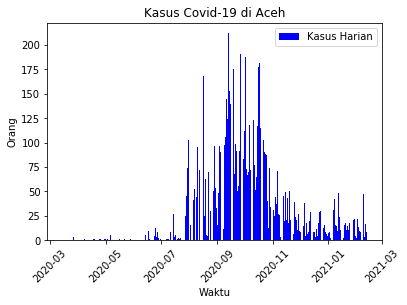

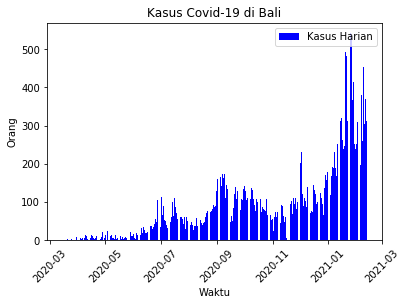

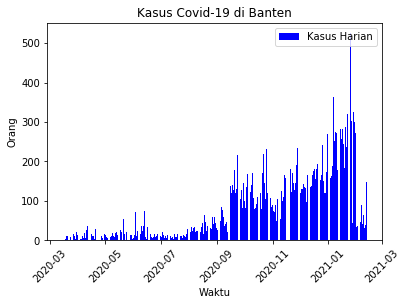

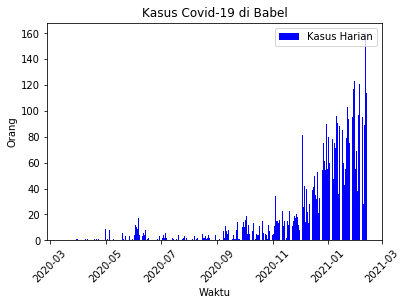

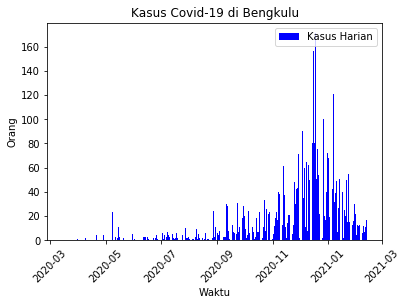

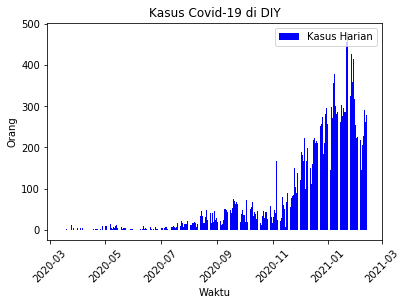

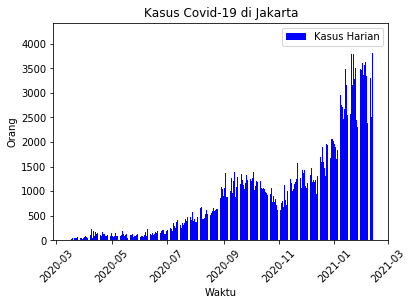

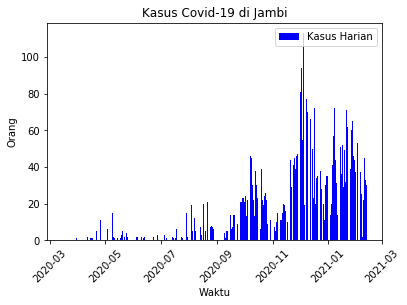

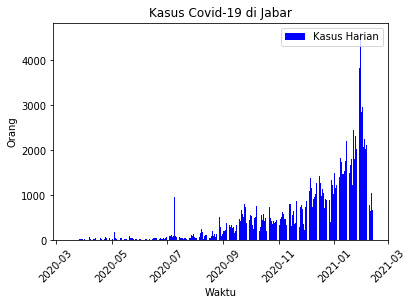

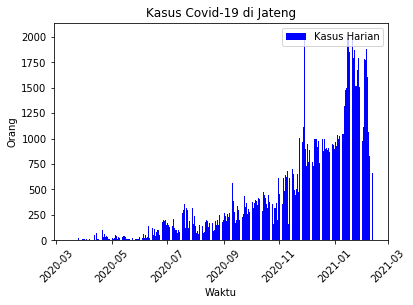

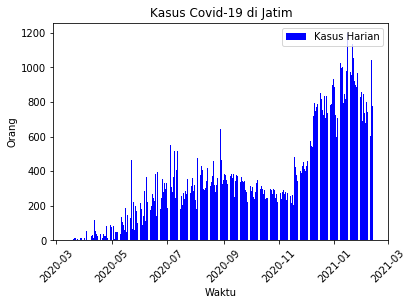

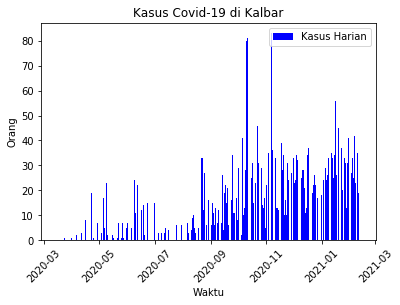

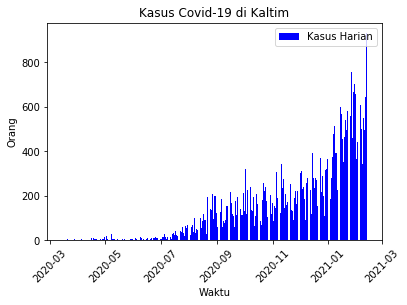

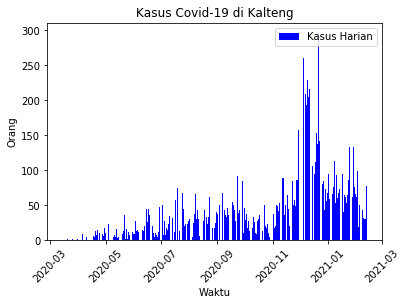

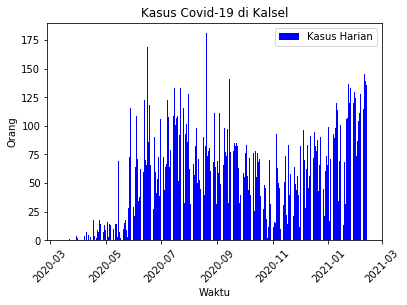

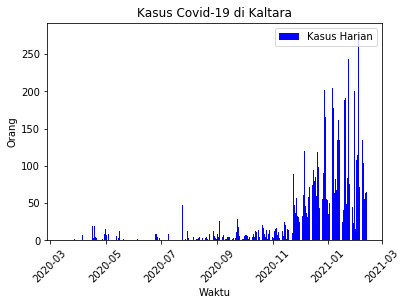

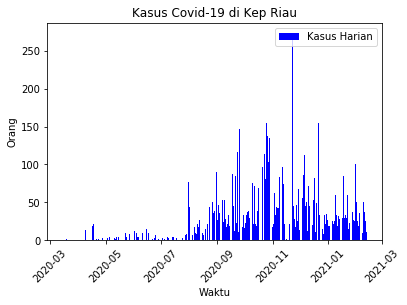

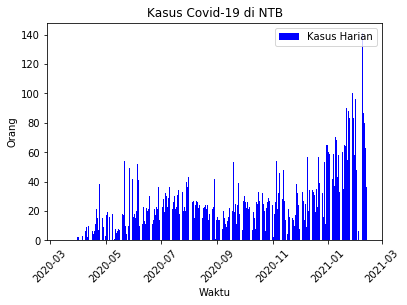

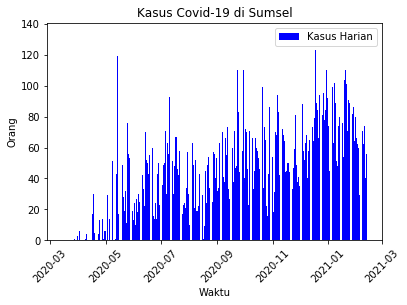

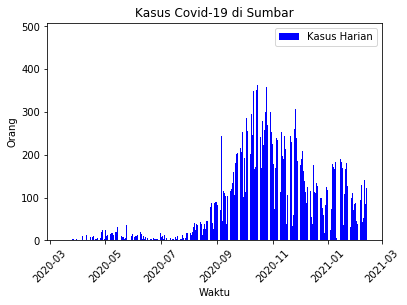

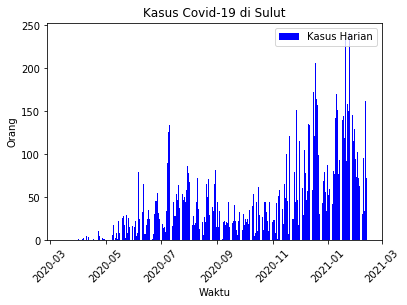

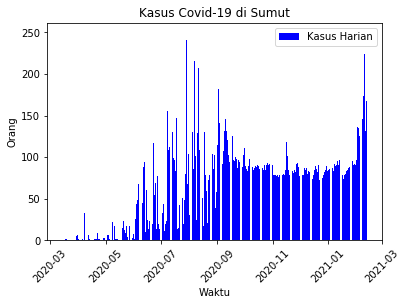

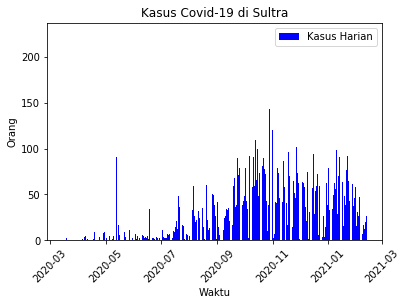

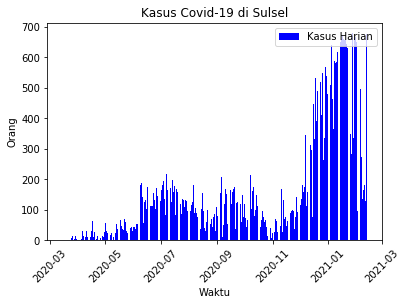

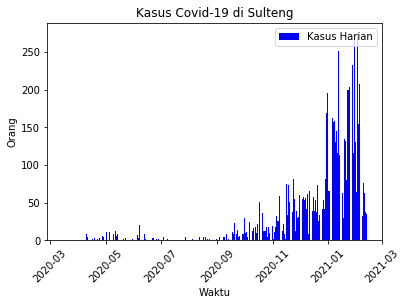

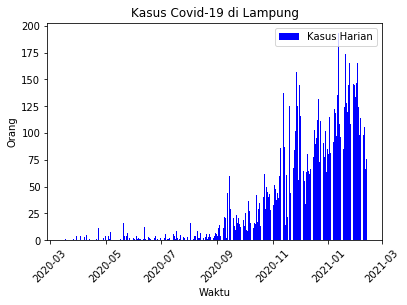

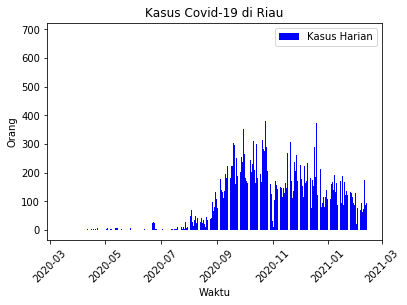

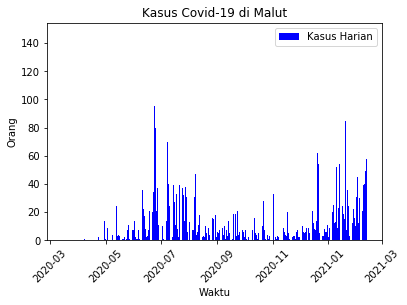

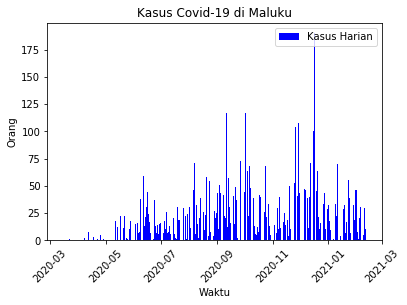

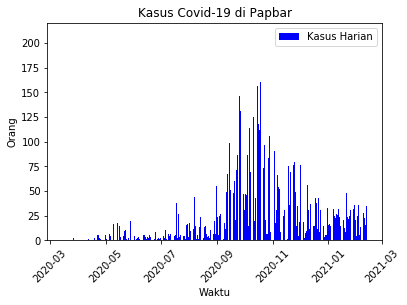

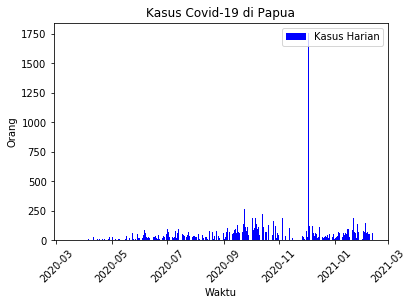

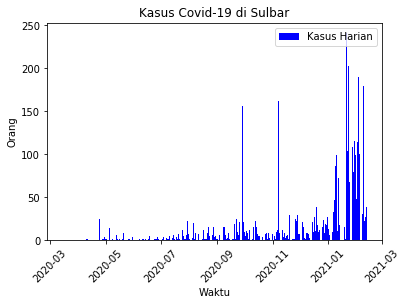

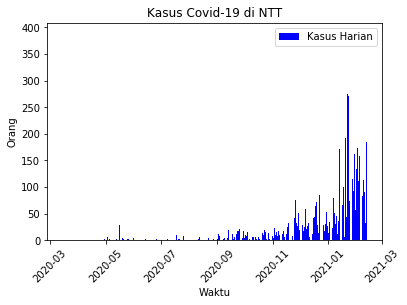

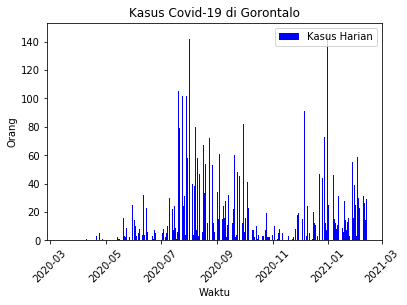

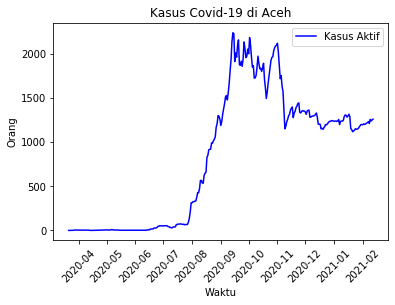

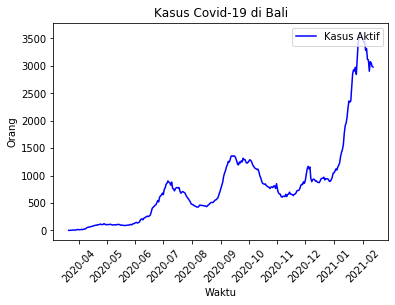

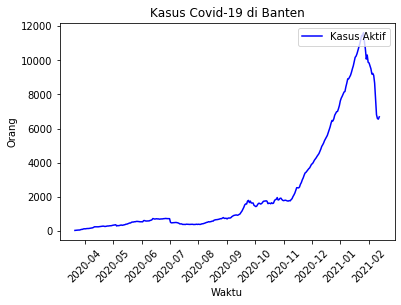

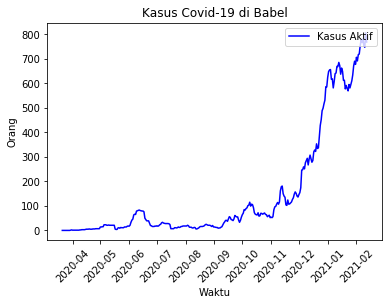

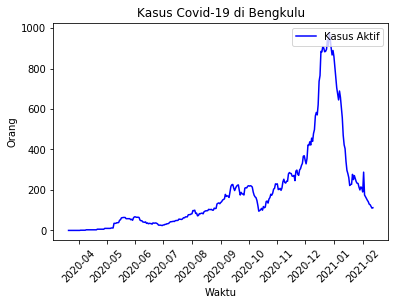

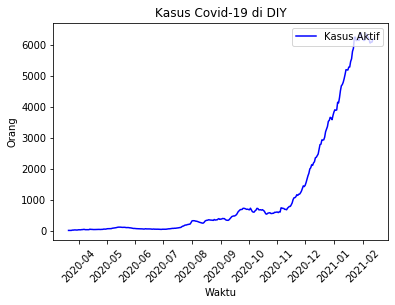

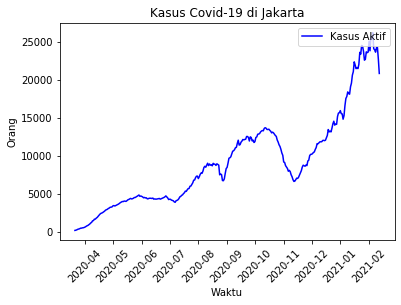

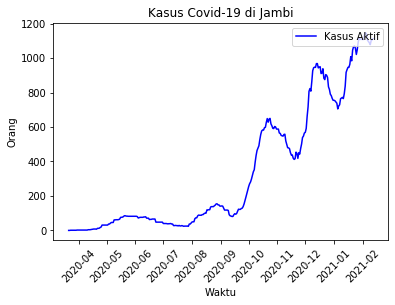

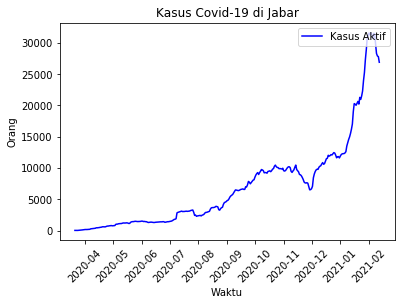

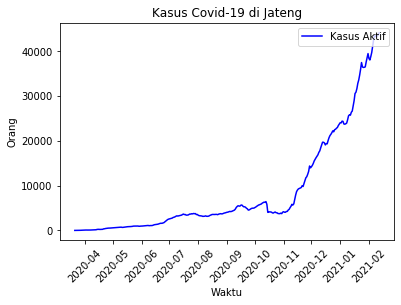

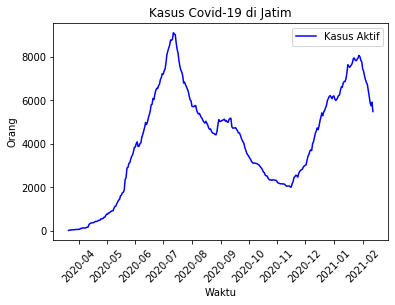

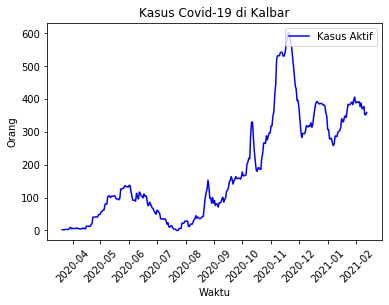

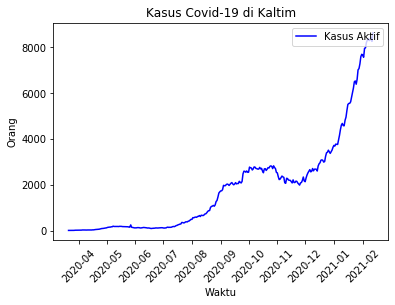

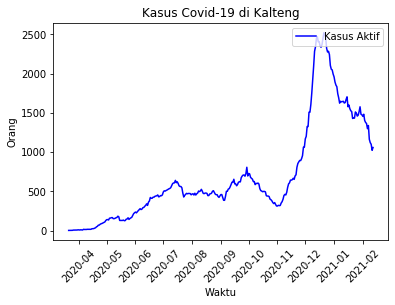

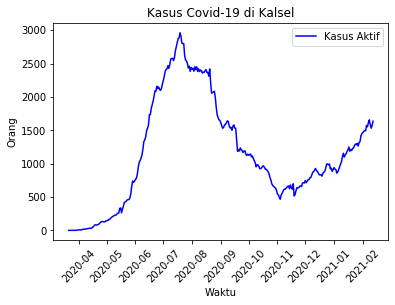

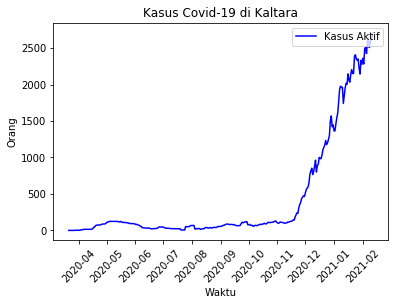

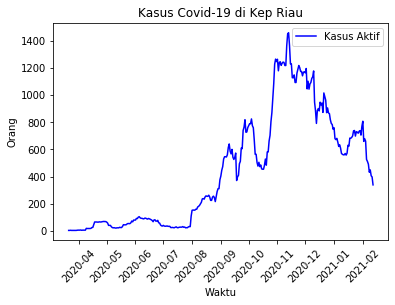

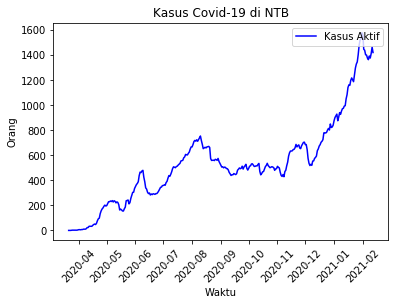

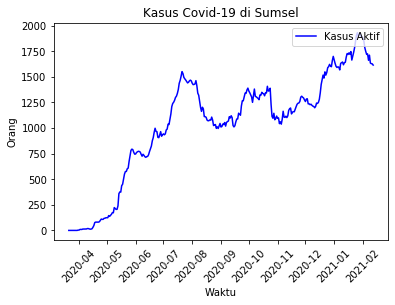

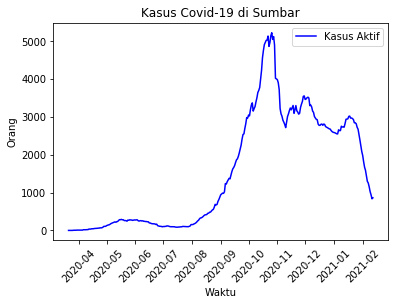

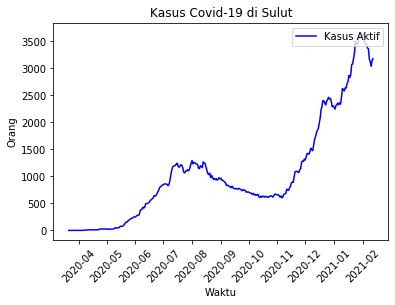

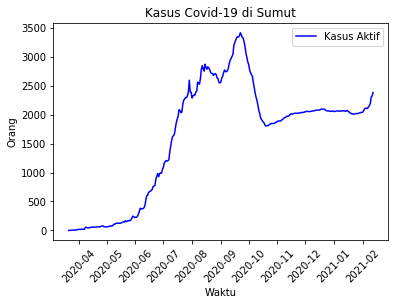

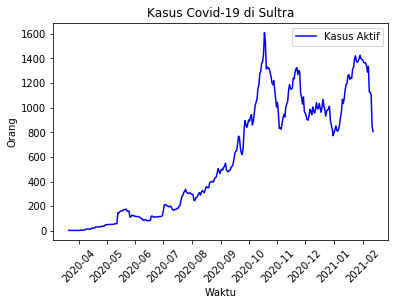

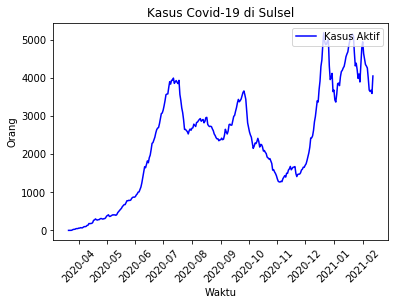

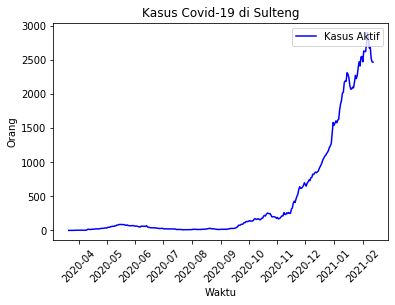

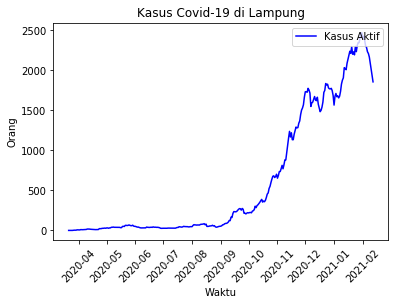

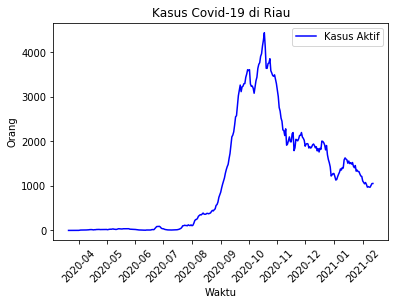

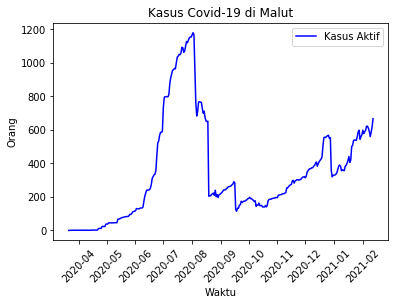

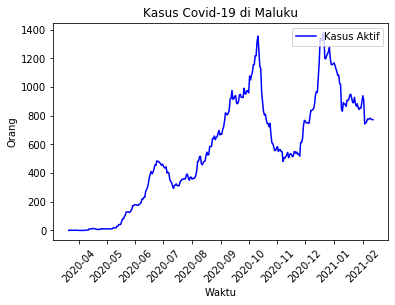

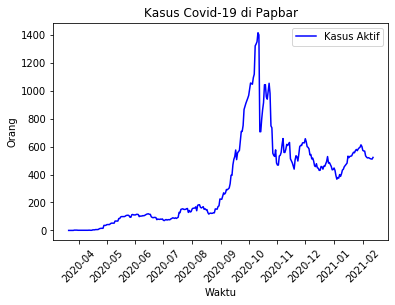

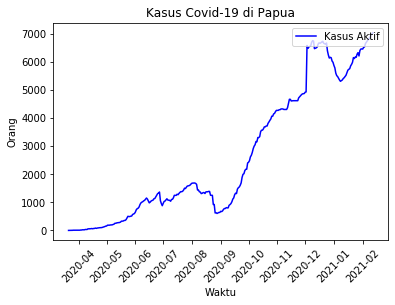

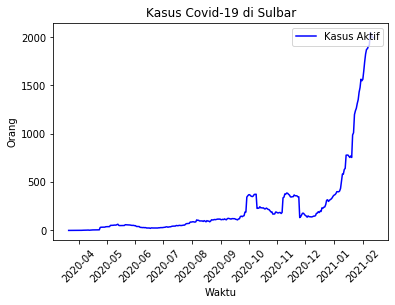

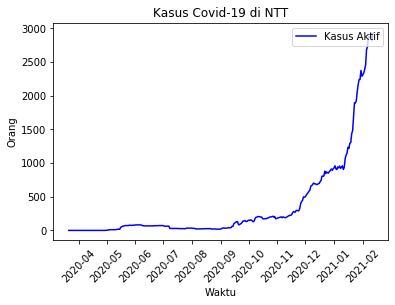

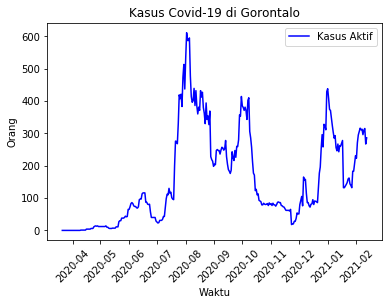

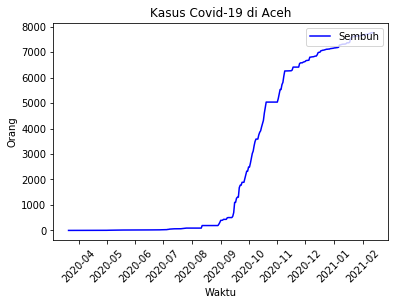

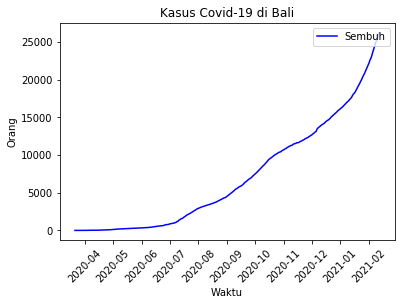

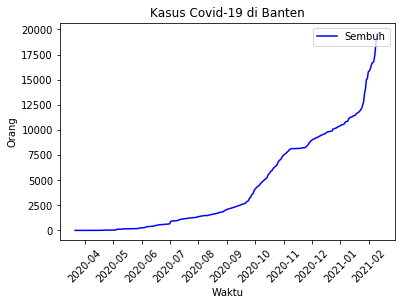

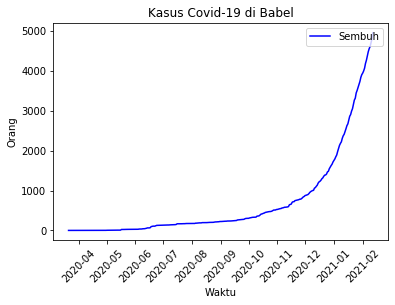

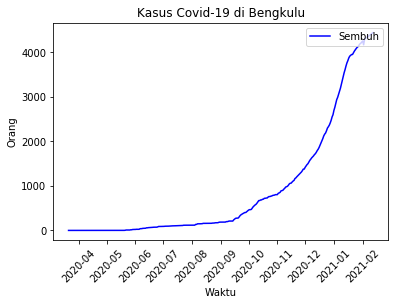

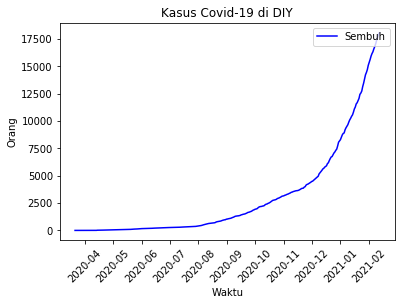

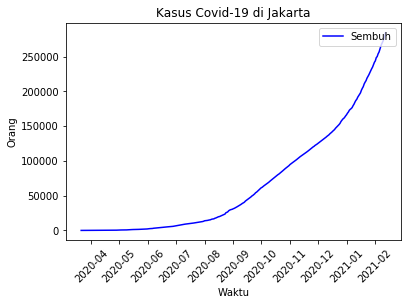

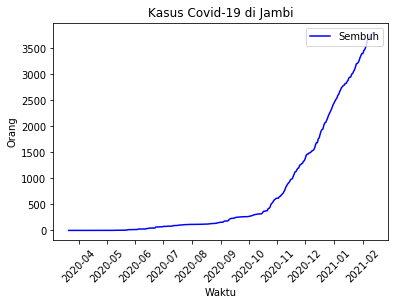

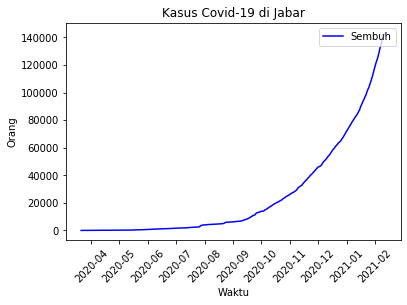

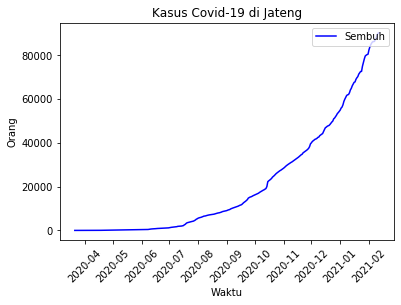

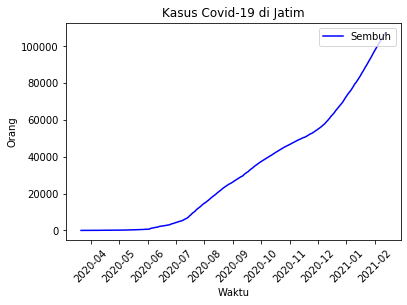

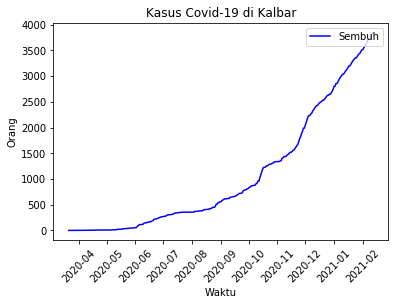

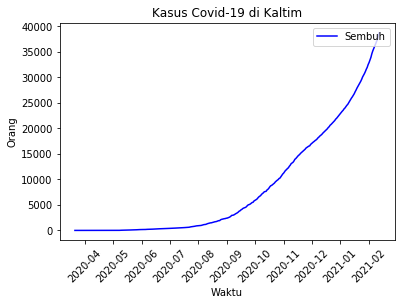

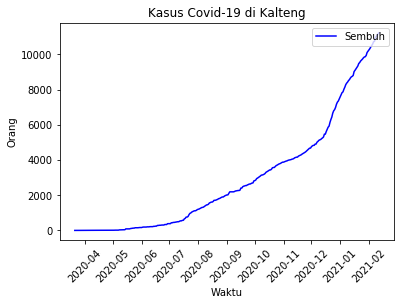

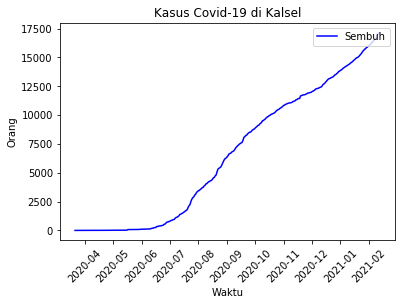

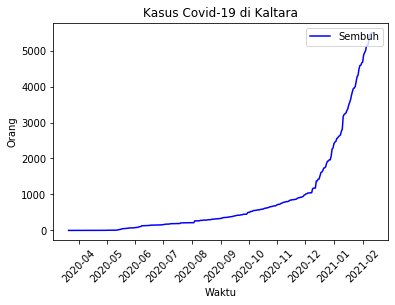

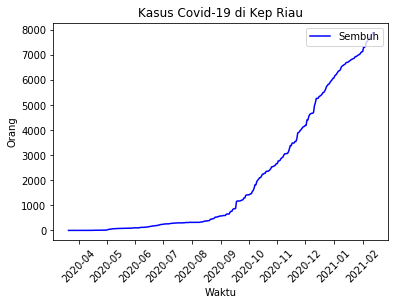

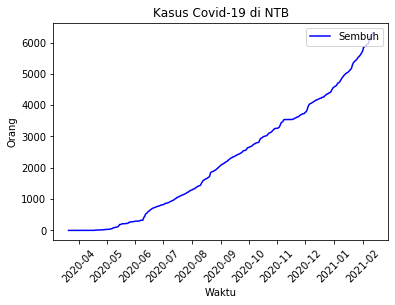

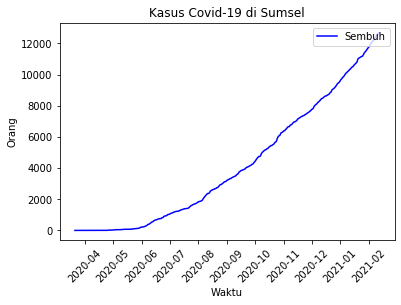

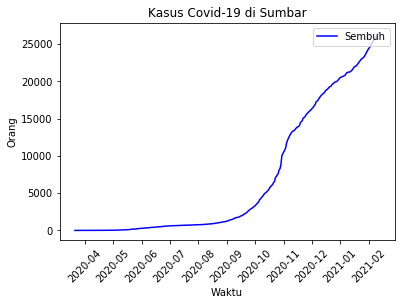

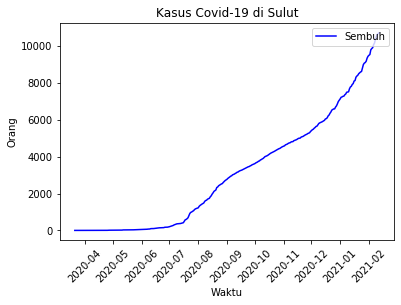

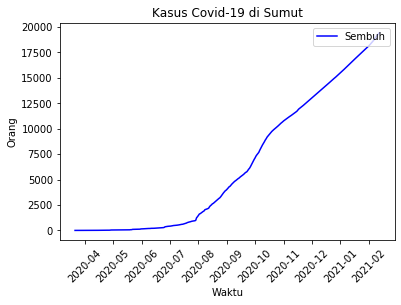

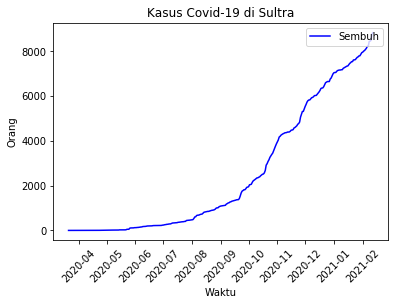

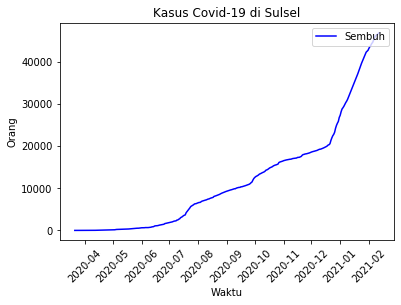

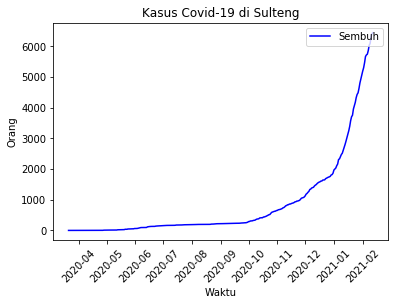

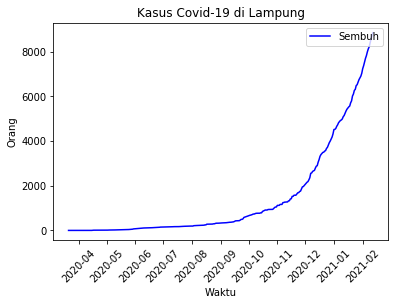

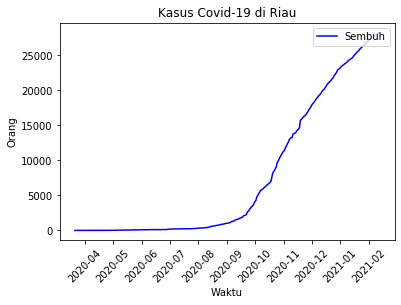

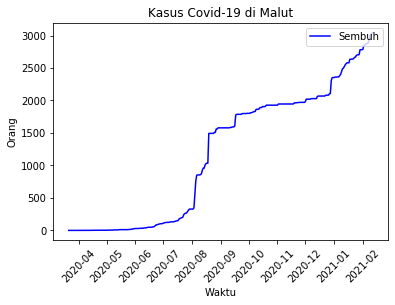

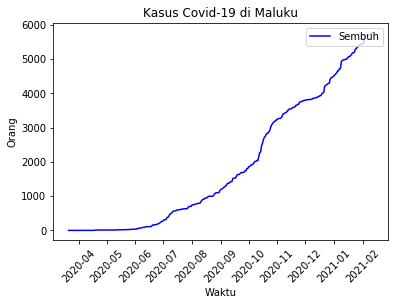

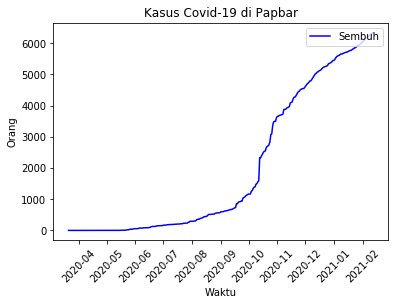

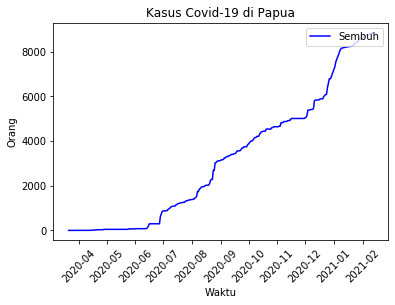

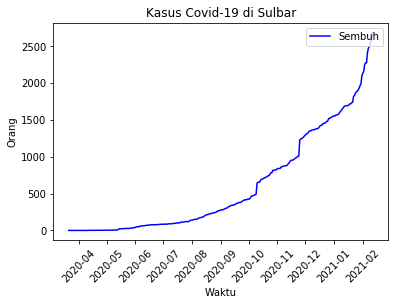

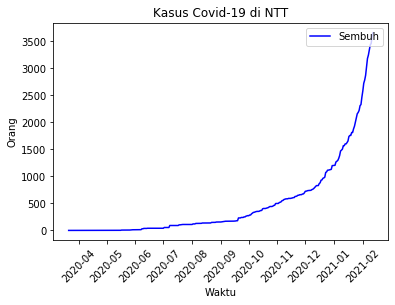

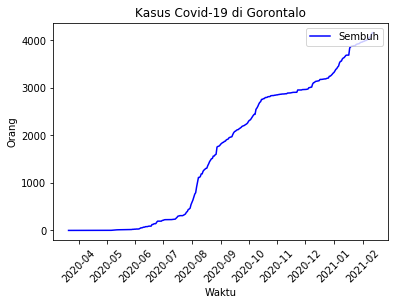

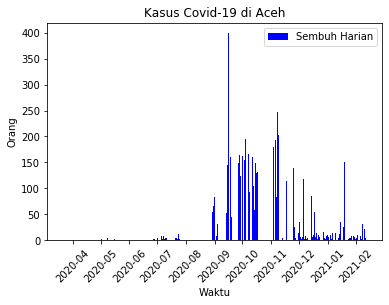

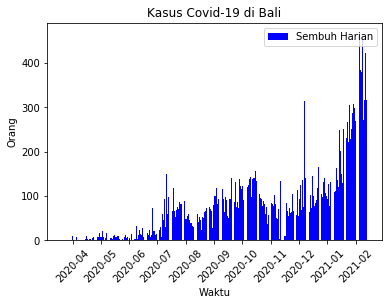

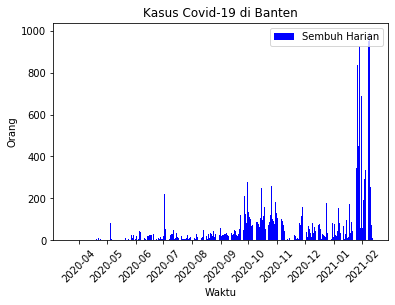

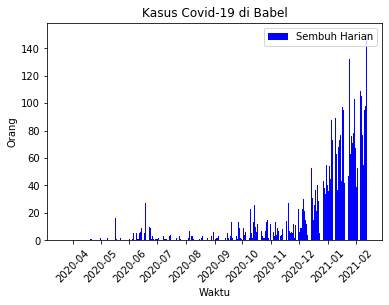

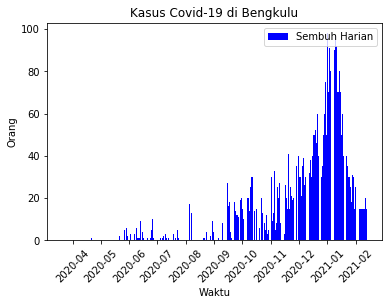

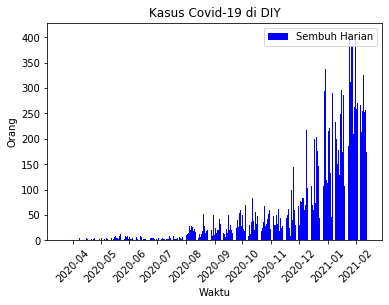

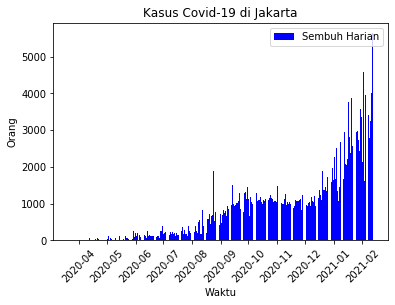

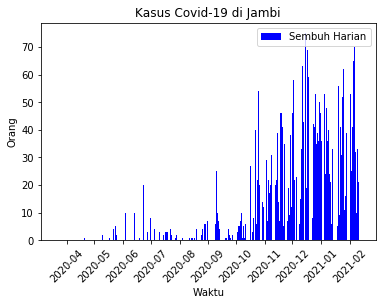

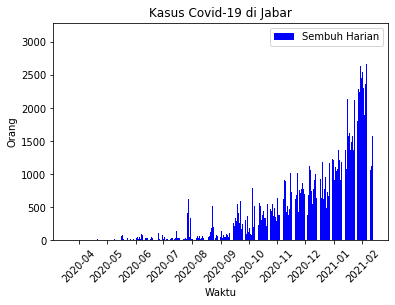

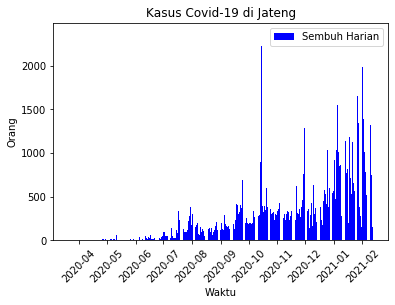

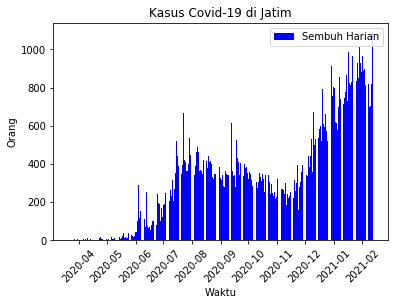

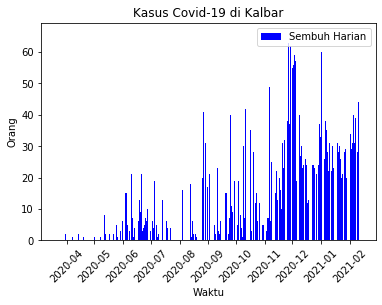

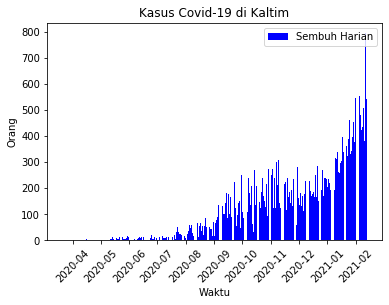

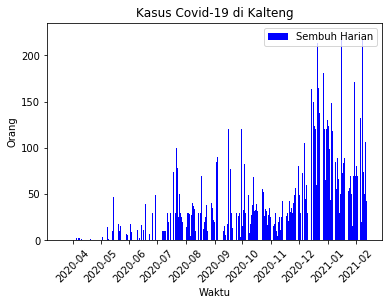

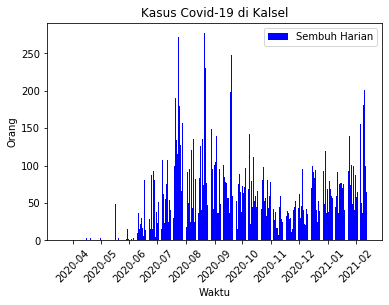

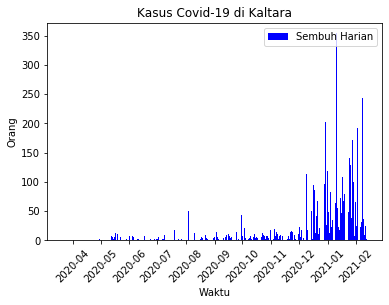

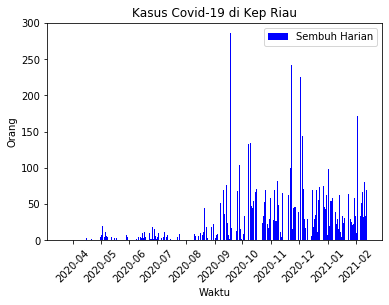

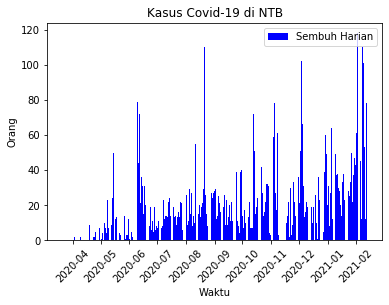

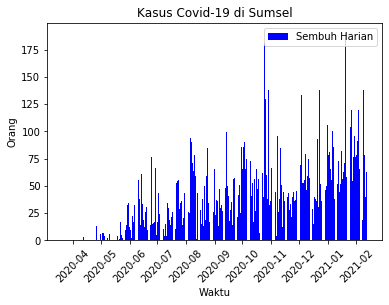

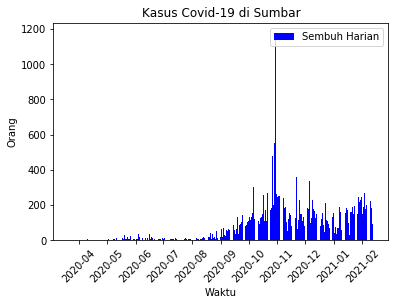

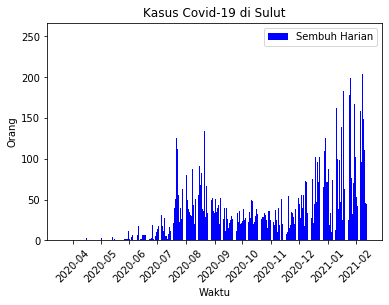

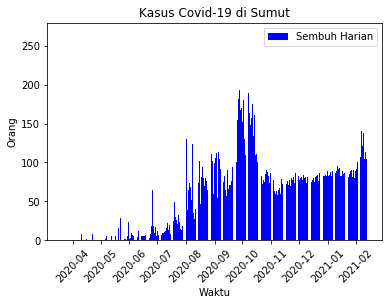

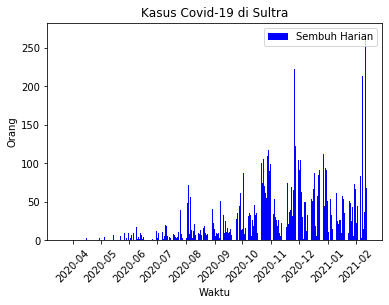

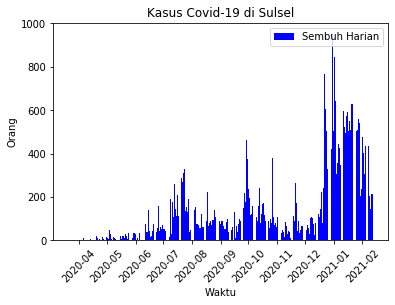

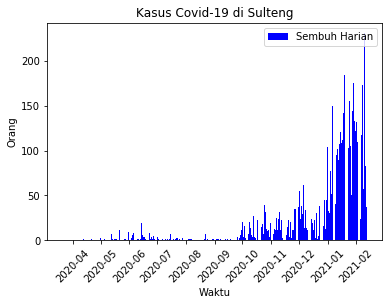

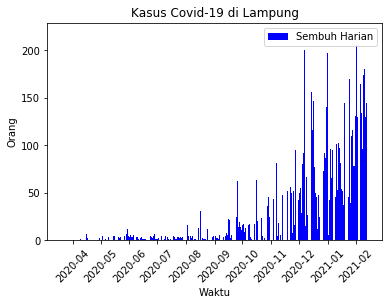

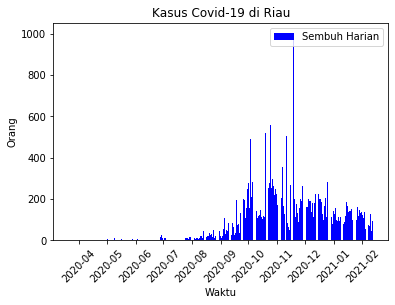

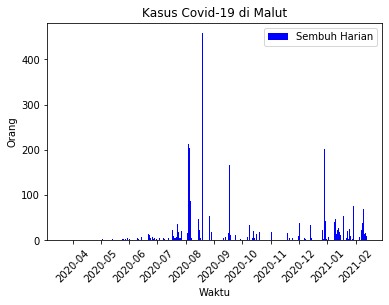

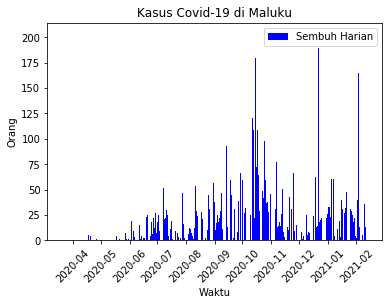

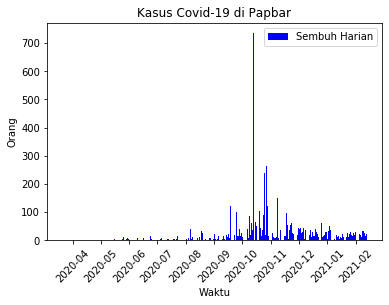

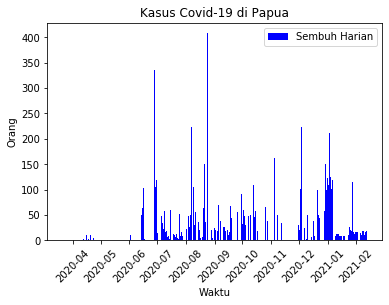

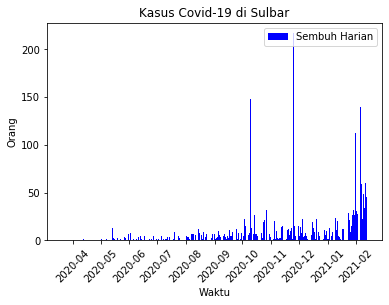

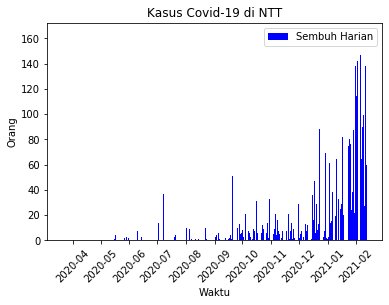

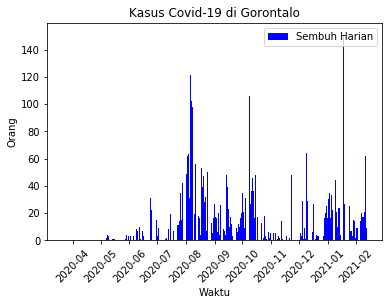

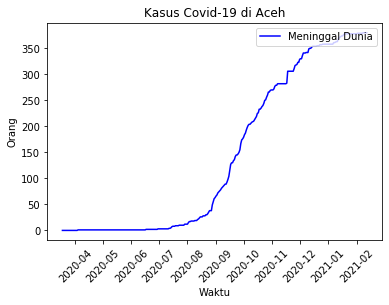

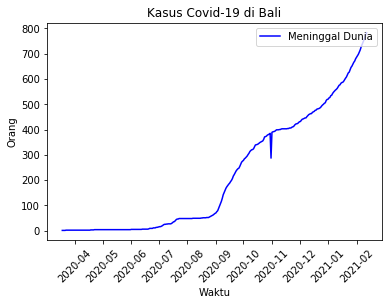

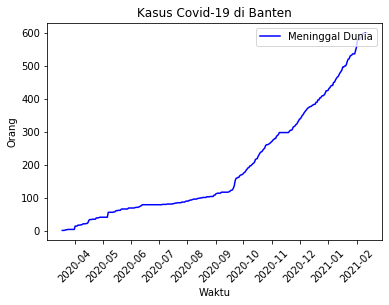

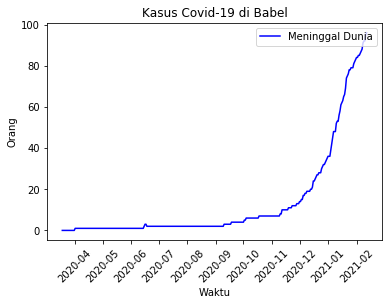

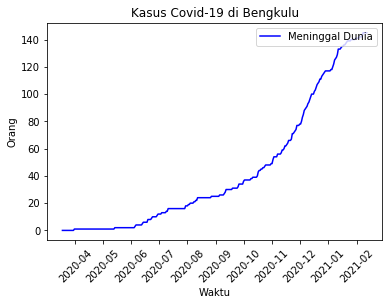

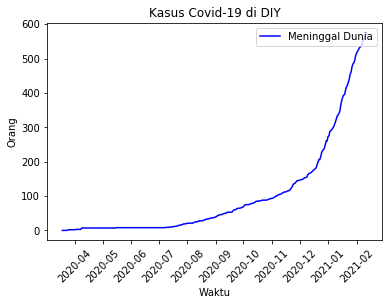

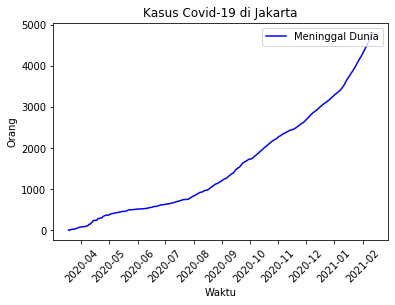

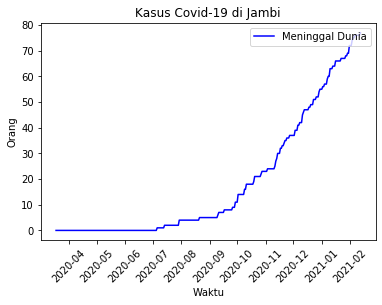

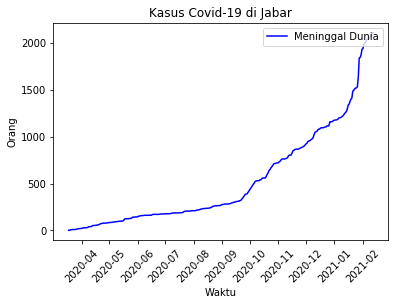

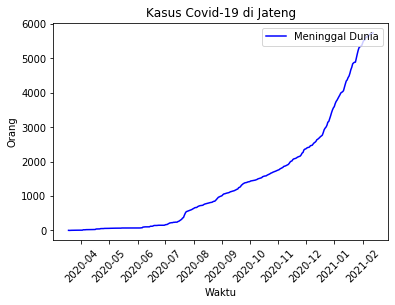

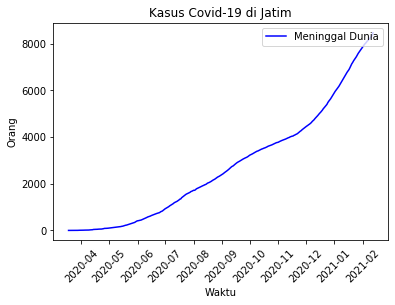

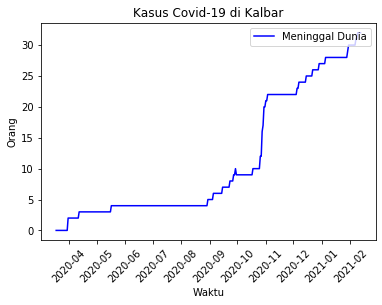

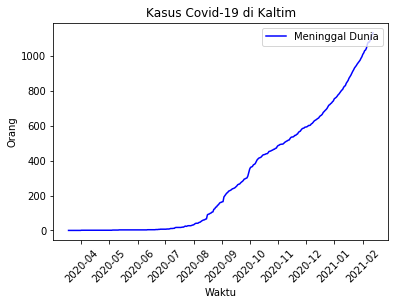

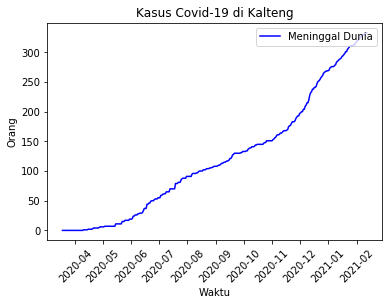

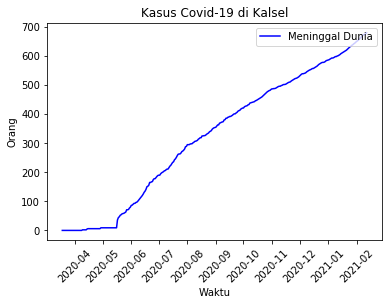

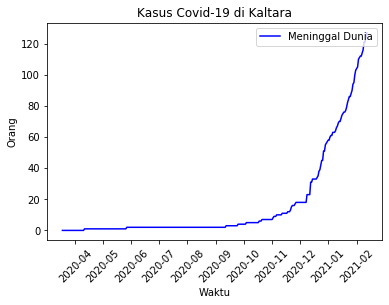

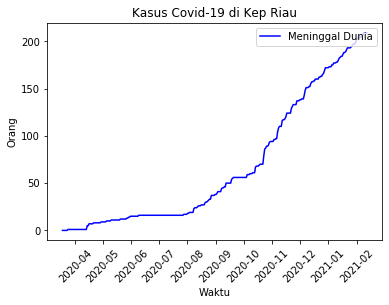

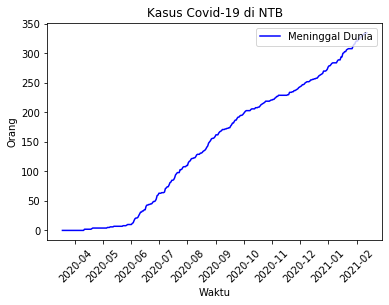

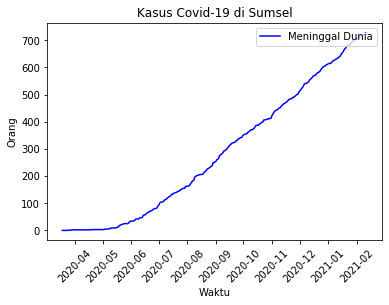

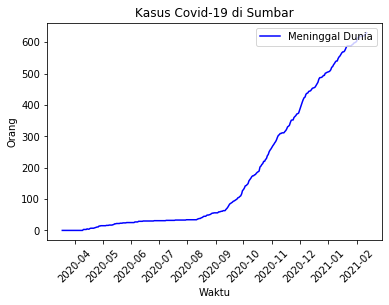

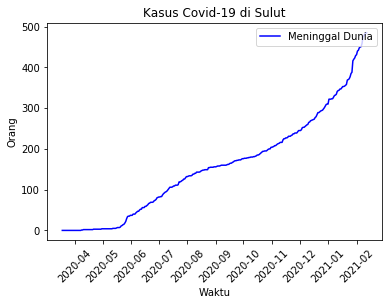

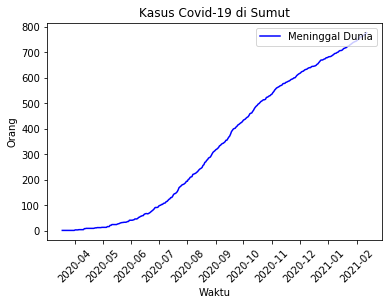

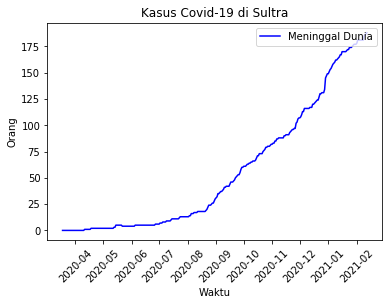

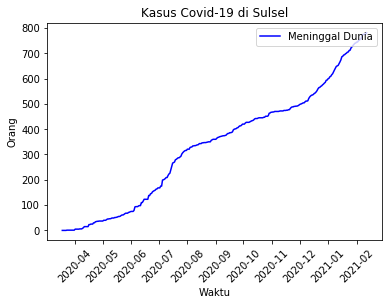

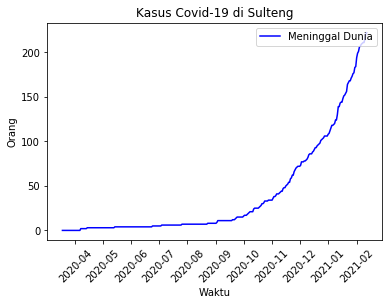

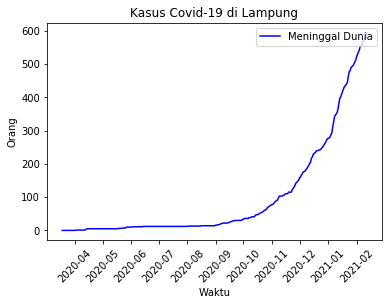

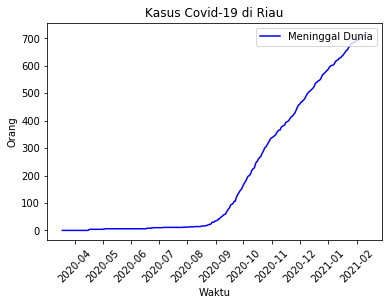

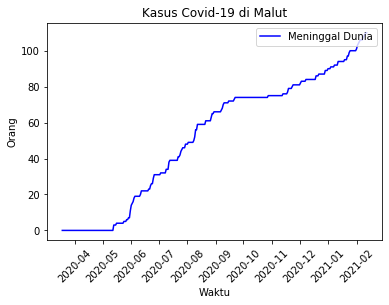

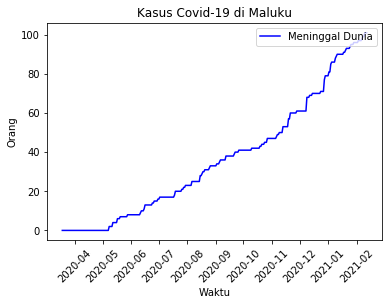

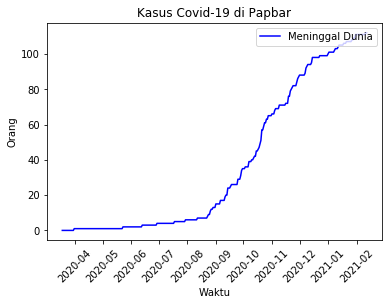

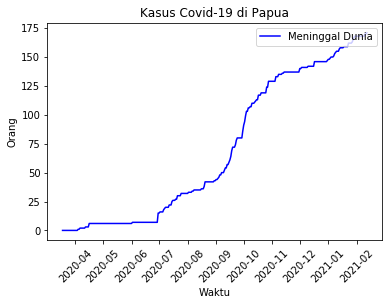

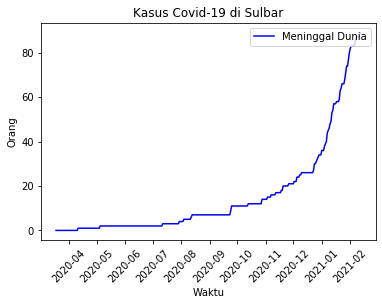

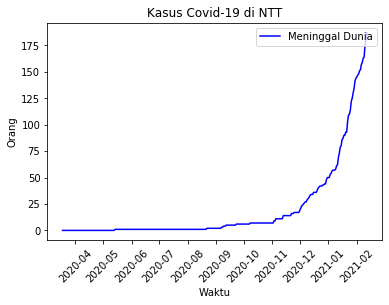

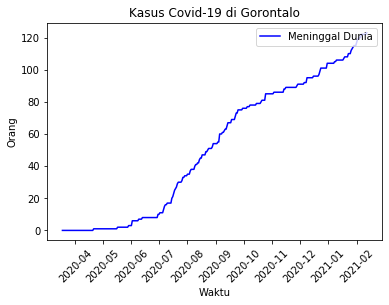

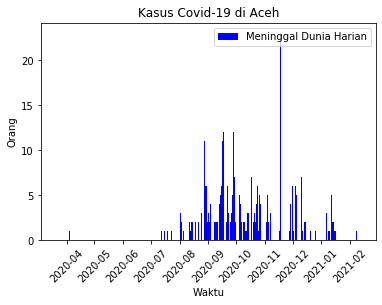

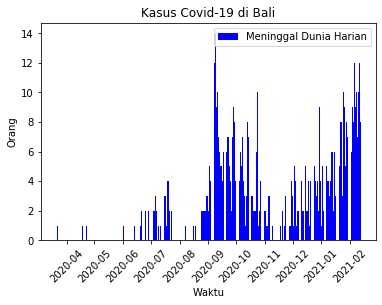

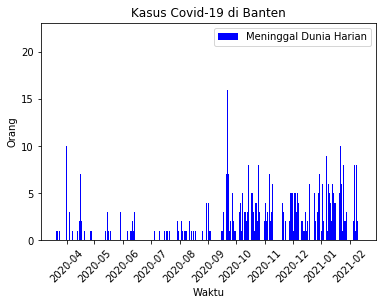

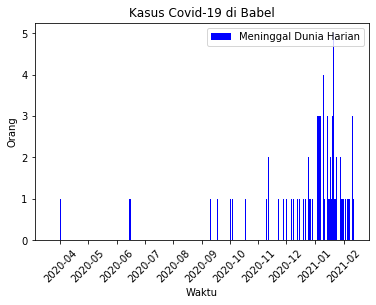

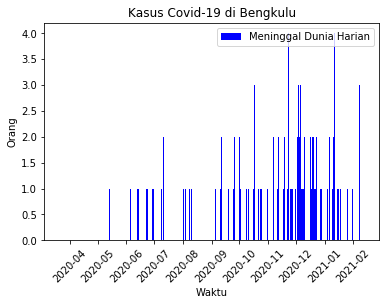

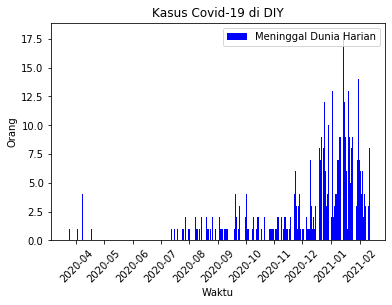

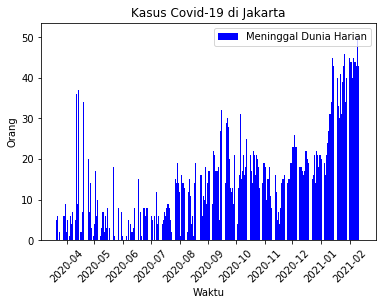

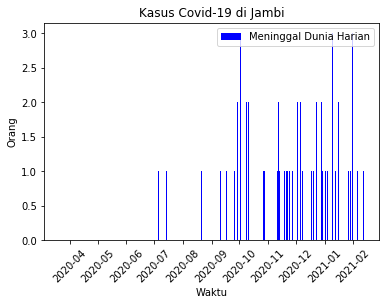

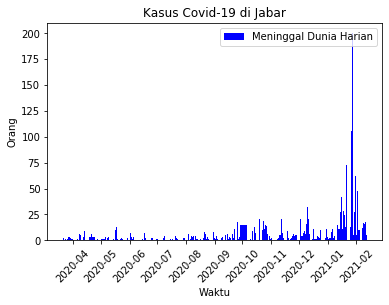

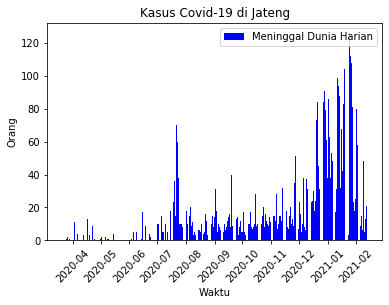

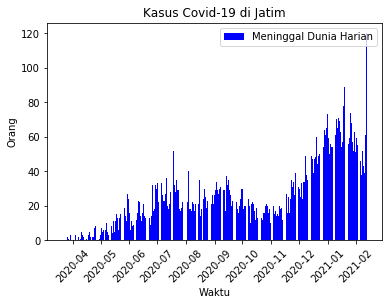

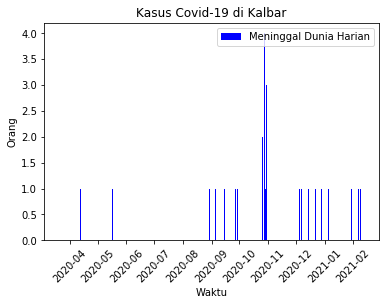

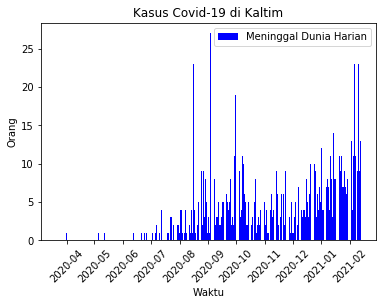

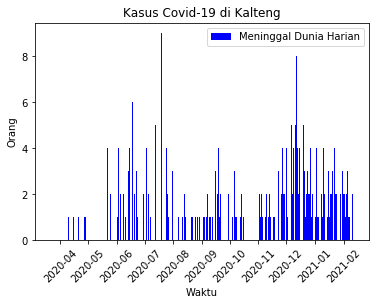

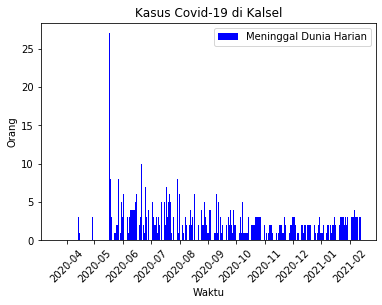

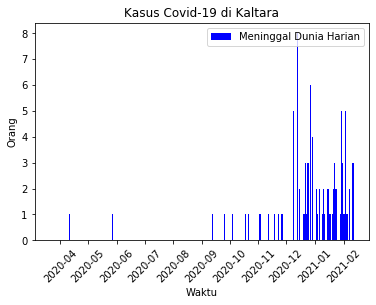

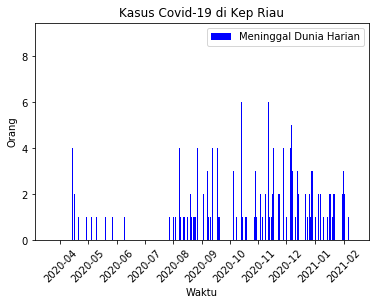

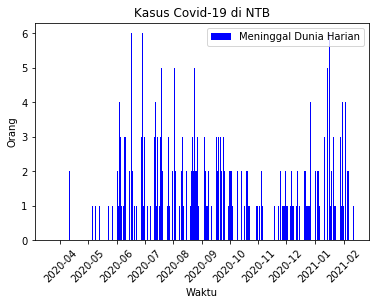

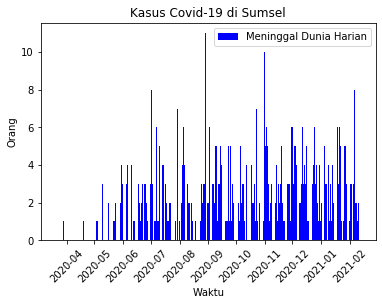

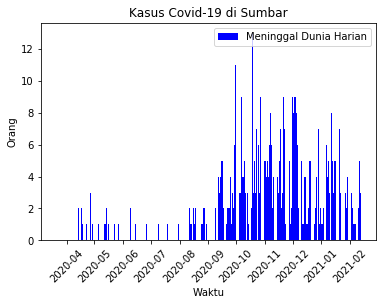

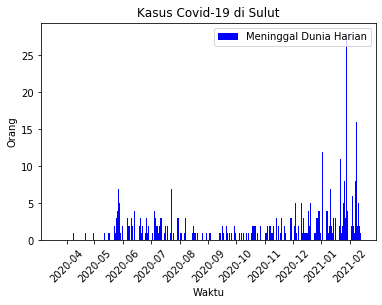

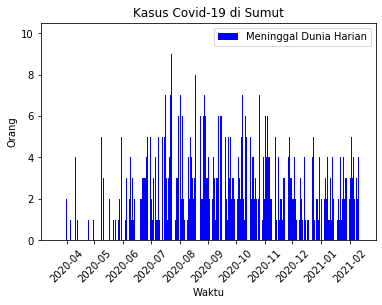

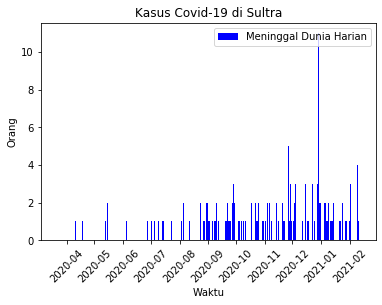

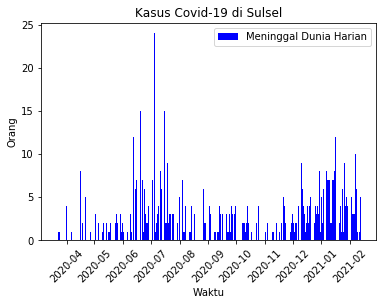

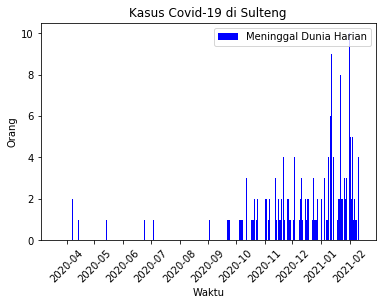

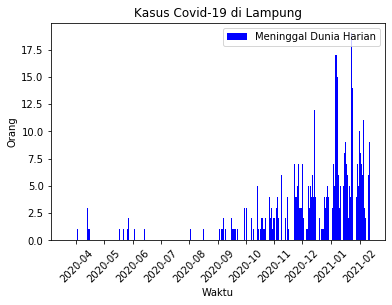

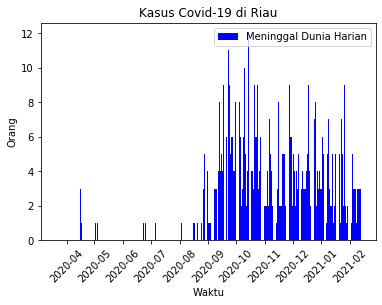

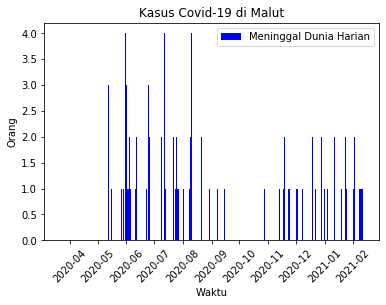

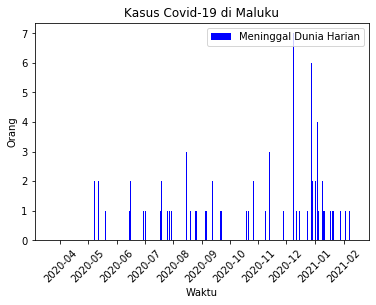

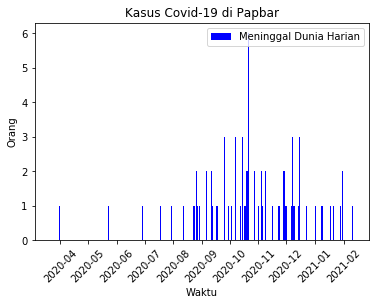

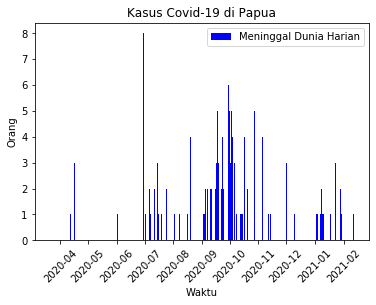

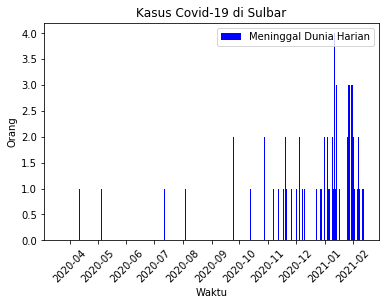

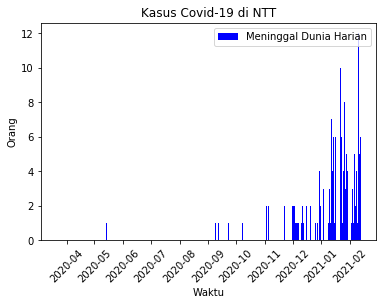

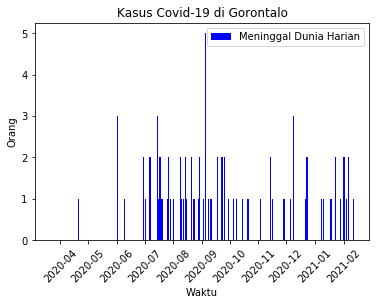

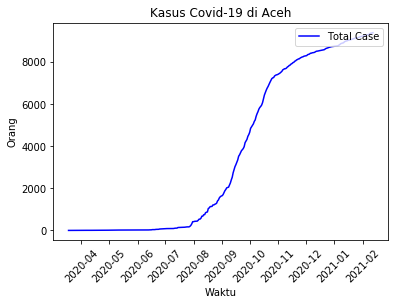

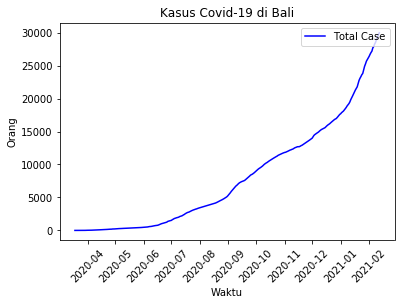

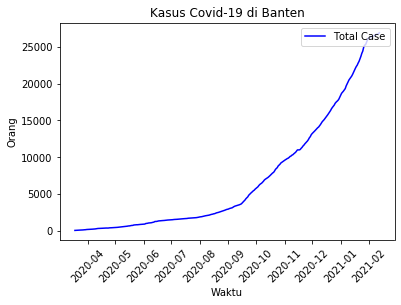

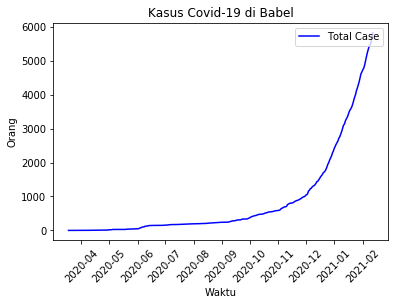

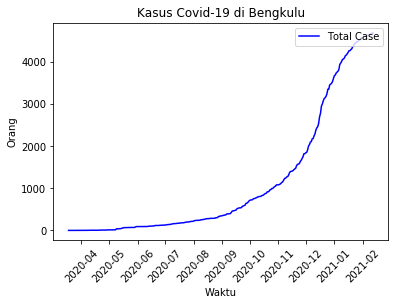

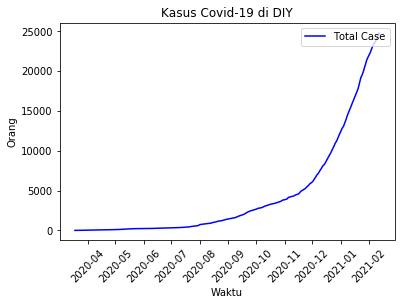

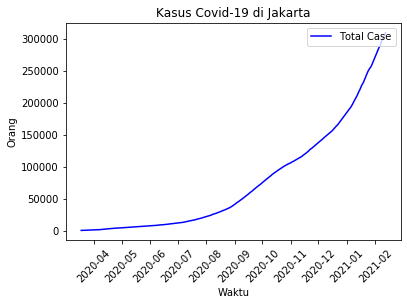

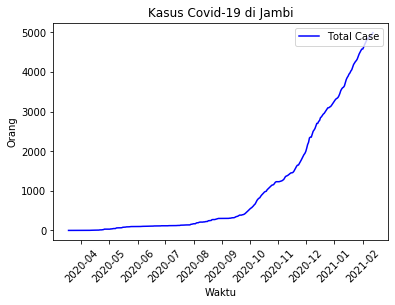

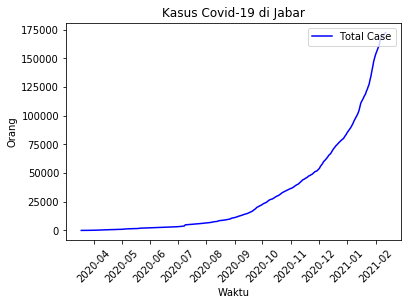

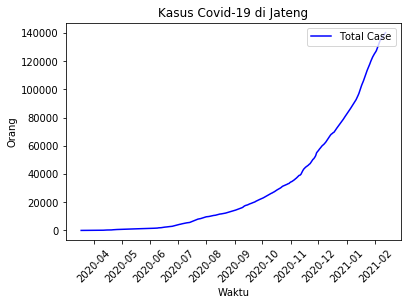

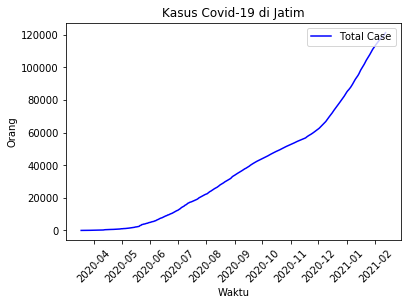

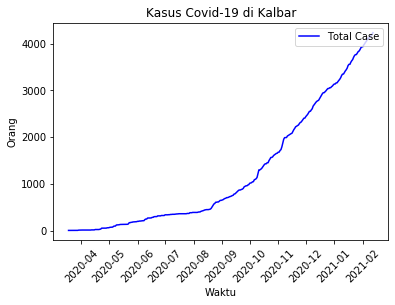

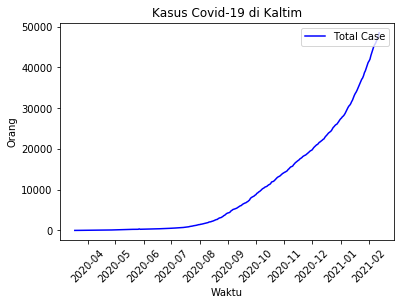

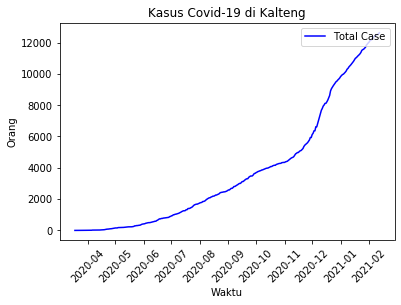

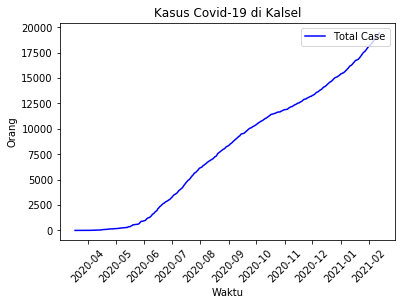

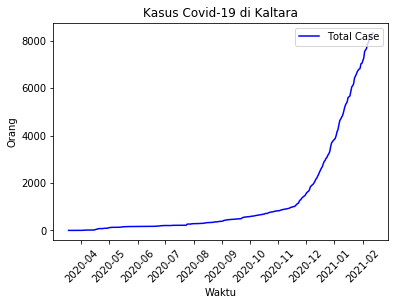

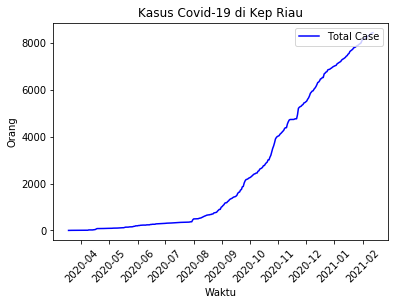

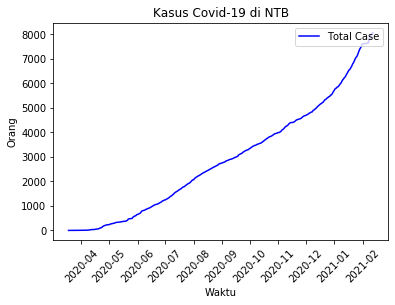

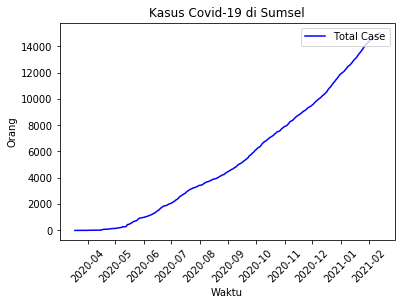

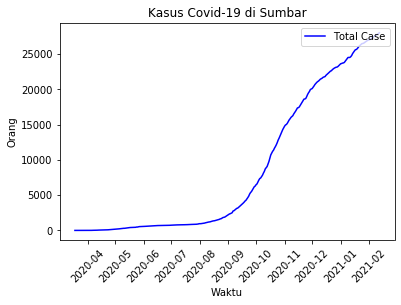

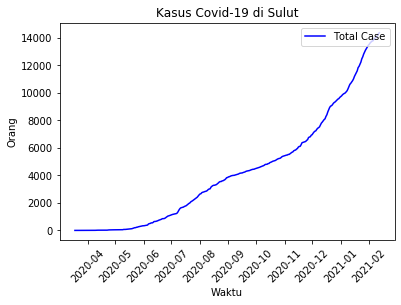

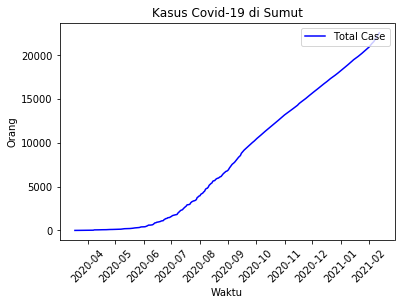

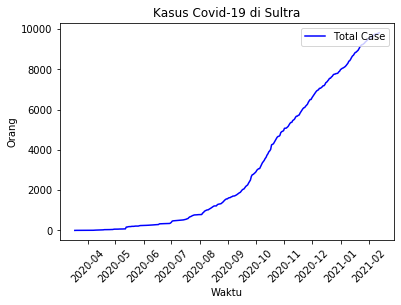

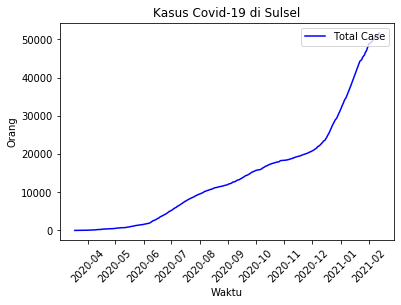

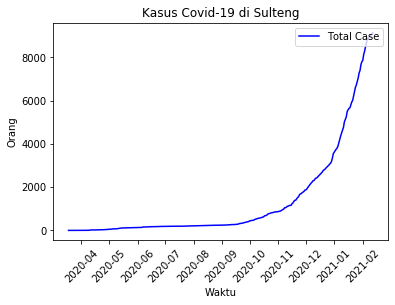

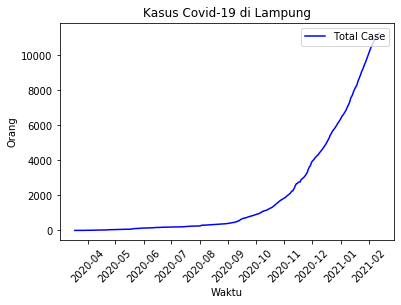

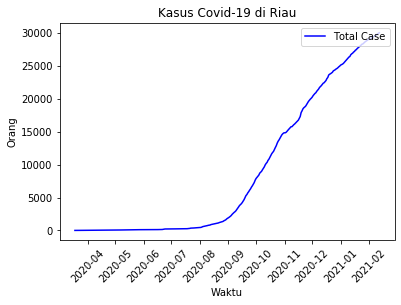

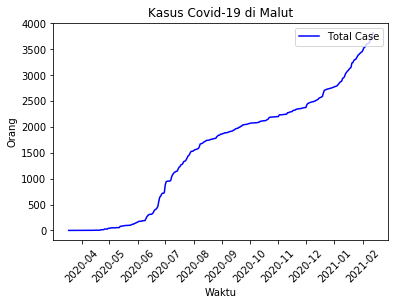

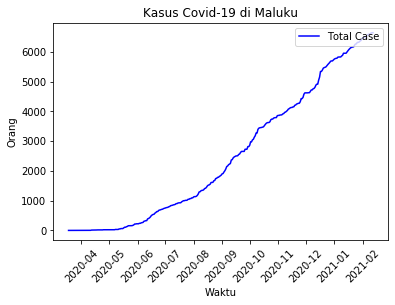

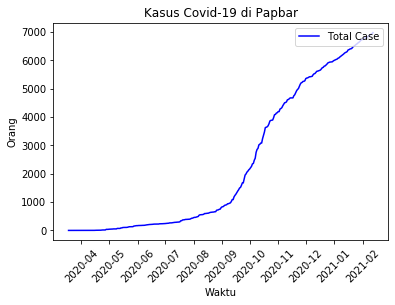

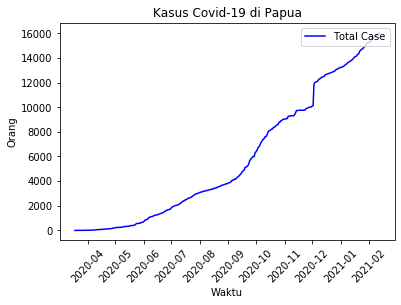

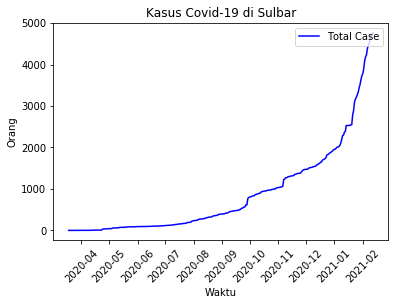

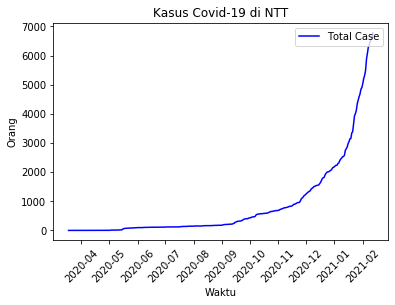

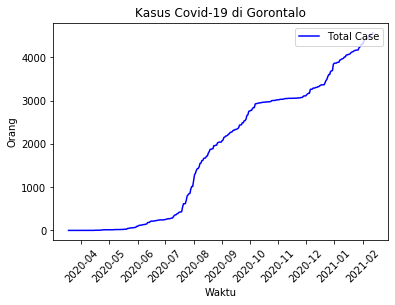

In [57]:
for category, df_category in df_categories.items():
    for province in df_category.columns:
        fig, ax = plt.subplots()
        
        if 'Harian' in category:
            ax.bar(df_category.index,df_category[province], color='b', label=category)
        else:
            ax.plot(df_category.index,df_category[province], color='b', label=category)
            
        ax.set_title('Kasus Covid-19 di {}'.format(province))
        ax.set_xlabel('Waktu')
        ax.set_ylabel('Orang')
        ax.legend(loc='upper right')
        plt.xticks(rotation=45)
        plt.savefig('image/indo_covid19_plot_{}_{}.png'.format(category, province), dpi=300)
        plt.show()
      

In [14]:
df_category.columns


Index(['Aceh', 'Bali', 'Banten', 'Babel', 'Bengkulu', 'DIY', 'Jakarta',
       'Jambi', 'Jabar', 'Jateng', 'Jatim', 'Kalbar', 'Kaltim', 'Kalteng',
       'Kalsel', 'Kaltara', 'Kep Riau', 'NTB', 'Sumsel', 'Sumbar', 'Sulut',
       'Sumut', 'Sultra', 'Sulsel', 'Sulteng', 'Lampung', 'Riau', 'Malut',
       'Maluku', 'Papbar', 'Papua', 'Sulbar', 'NTT', 'Gorontalo'],
      dtype='object')